# Analysis of Experiment P1902

## Outline

1.  [Loading data](#Loading).  See the P1902 Preprocessing notebook, for the preparation of this data. 

2.  [Protein and mRNA distributions](#Protein) within and between clones for markers where we have information about both.

3. [Gene expressions as a signature of clonality](#Signature)  A machine learning approach to studying whether gene expression can predict clonotype.

4. [Differential gene expression](#DGE), including within and across traditional EFF/MEM categories.

<a id='Loading'></a>
# 1.  Loading and munging data

We begin by importing various packages and functions.  This notebook requires Python 3.5 or later, together with numpy, pandas, matplotlib, seaborn, statsmodels, scipy, scikit-learn (sklearn), bisect, and itertools.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
import statsmodels.api as sm

from IPython.display import display # Pretty display of data frames.

# Import various functions for stats.
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew, zscore # For detecting bimodality
import scipy.cluster.hierarchy as sch # For hierarchical clustering.

from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.manifold import TSNE

# Put plots inline rather than in a pop-up.
%matplotlib inline

//anaconda/envs/Genomics/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


All data should be available from three pickles, produced by the Preprocessing notebook.

In [2]:
EM = pd.read_pickle('P1902_EM.pkl') # Load normalized expression matrix from a pickle.
EM_bulks = pd.read_pickle('P1902_EM_bulks.pkl') # Load normalized expression matrix from a pickle.
protein_df = pd.read_pickle('P1902_protein.pkl') # Load proteins from a pickle.
meta_df = pd.read_pickle('P1902_meta.pkl') # Load metadata from a pickle.
gene_df = pd.read_pickle('P1902_genes.pkl') # Load metadata from a pickle.

We retrieve lists of genes, cells, and proteins from the loaded data.  The MEM/MIX/EFF clones are defined here (from knowledge of the experiment).

In [3]:
genes = list(EM.columns)  # The names of the genes. 
cells = list(EM.index) # The names of the cells.
bulks = list(EM_bulks.index) # The names of the bulks.

proteins = list(protein_df.columns) # The names of the proteins
paired_proteins = [p for p in proteins if p in genes] # Proteins with paired genes.


clone_groups = {'MEM': ['H2', 'B4'], 'A7': ['A7'], 'EFF':['G6', 'A8', 'G8', 'H9', 'F3'], 'E4':['E4']}
clones = [clone for clonegroup in clone_groups.values() 
          for clone in clonegroup] #Pythonic flattening of list.
print(clones) # Convenient reordering of clones, MEM then A7 then EFF then E4.

['H2', 'B4', 'A7', 'G6', 'A8', 'G8', 'H9', 'F3', 'E4']


We add MEM/MIX/EFF classification to the metadata.

In [4]:
def emm(clone):
    if clone in clone_groups['MEM']:
        return 'MEM'
    elif clone in clone_groups['EFF']:
        return 'EFF'
    else:
        return 'MIX'

meta_df['cell_type'] = meta_df['Clone_ID'].apply(emm)

`meta_df` is the dataframe holding the "metadata" of each cell (not the gene/protein expressions).  Let's just look at the first five cells, to see what the metadata looks like.

In [5]:
meta_df[:5]

,Condition,Cell_Number,Clone_ID,Day,Project_ID,cell_type
P1902_1289,In_Vitro,1.0,E4,NaN,P1902,MIX
P1902_1290,In_Vitro,1.0,E4,NaN,P1902,MIX
P1902_1291,In_Vitro,1.0,E4,NaN,P1902,MIX
P1902_1292,In_Vitro,1.0,E4,NaN,P1902,MIX
P1902_1293,In_Vitro,1.0,A7,NaN,P1902,MIX


Here we load a list of genes that are known to play a role in the memory (MEM) vs. effector (EFF) distinction. 

In [6]:
genes_me = pd.read_csv('MEM_EFF_List_Genes.csv').iloc[:,0].tolist()
genes_me = [gene for gene in genes_me if gene in genes]
print('{} MEM/EFF genes found in list of genes.'.format(len(genes_me)))

130 MEM/EFF genes found in list of genes.


Here we load a list of genes that are known to be innate immune genes, plus a few extras.

In [119]:
innate_df = pd.read_csv('InnateDB_genes.csv')
extragenes = pd.read_csv('marty-extra_genes.csv')
genes_innate = set(innate_df.name.unique()).union(set(extragenes.name.unique()))
genes_innate = sorted(genes_innate)
print('There are {} innate genes loaded, starting with {}'.format(len(genes_innate), genes_innate[:5]))

There are 828 innate genes loaded, starting with ['A2M', 'A2ML1', 'ABCB1', 'ABCF1', 'ACE']


For future convenience, we sort clones into MEM/MIX/EFF groups based on prior clonal identification.

In [8]:
cells_eff = meta_df[ meta_df['cell_type'] == 'EFF'].index
cells_mix = meta_df[ meta_df['cell_type'] == 'MIX'].index
cells_mem = meta_df[ meta_df['cell_type'] == 'MEM'].index

The following carries out a log-normalization on the protein expression data.

In [9]:
prolog = protein_df.copy()  # Make a copy in memory
prolog = prolog.apply(lambda column: column - column.min()) # Shift minima to zero.
prolog = prolog.transform(np.log1p) # Apply log(1+x) transform.

The following summarizes the data that has been loaded.  Double-check this, to make sure it matches expectation.

In [10]:
print("The expression matrix captures {} cells and {} gene expressions.".format(len(cells), len(genes)))
print("The protein matrix captures {} cells and {} proteins.".format(len(prolog), len(proteins)))
print("There are {} proteins paired with genes: {}.".format(len(paired_proteins), ', '.join(paired_proteins)))
print("Our cell metadata contains {} cells in {} clonotypes.".format(len(cells), len(clones)))
print("There are {} EFF-identified and {} MEM-identified cells.".format(len(cells_eff), len(cells_mem)))

The expression matrix captures 345 cells and 7405 gene expressions.
The protein matrix captures 361 cells and 24 proteins.
There are 5 proteins paired with genes: FAS, CD3E, CD8A, PDCD1, CD27.
Our cell metadata contains 345 cells in 9 clonotypes.
There are 178 EFF-identified and 90 MEM-identified cells.


<a id='Protein'></a>
# 2.  Protein / mRNA expression among clones.

We look at the relationship between protein and mRNA expression within and between clones.  At the single-cell level, within a clonotype, we can examine the location of a cell in "protein/gene space".  This leads to distributions for each clone, and these distributions vary between clones.

We begin the analysis by creating a dataframe with just the data of protein expression, matched gene expression, and a bit of metadata.

In [16]:
def make_pgframe(gf, pf, md, IV = True):
    serieslist = []
    cell_list = list(gf.index)
    for p in paired_proteins:
        p_df = pd.concat([gf.loc[pf.index & gf.index][p], 
                          pf.loc[pf.index & gf.index][p]], 
                         axis=1)
        p_df.columns = [p+'_gene', p+'_protein'] # Separate headers for gene and protein.
        serieslist.append(p_df)
    df = pd.concat(serieslist, axis=1)
    df['Clone_ID'] = md.loc[gf.index].Clone_ID # Add clonality information.
    if IV:
        df['In_Vivo_Clone_ID'] = md.loc[gf.index].In_Vivo_Clone_ID # Add in-vivo
    return df

We create the dataframe, and take a look at the first five cells.

In [17]:
pg_df = make_pgframe(EM, prolog, meta_df, IV=False)
display(pg_df[:5])

,FAS_gene,FAS_protein,CD3E_gene,CD3E_protein,CD8A_gene,CD8A_protein,PDCD1_gene,PDCD1_protein,CD27_gene,CD27_protein,Clone_ID
P1902_1289,0.000000,7.237059,4.457231,6.576470,5.710748,10.276498,0.000000,6.848005,6.497251,6.253829,E4
P1902_1290,0.000000,9.118335,4.518180,7.882692,6.342390,9.105646,0.000000,6.363028,0.000000,7.280008,E4
P1902_1291,0.000000,8.366138,5.890155,7.889834,6.392752,10.095759,5.534023,7.160846,5.465269,6.822197,E4
P1902_1293,5.998420,8.127995,5.366696,8.052296,4.430029,9.688622,0.000000,3.988984,6.397186,7.848543,A7
P1902_1294,5.906926,7.507690,6.484743,7.170120,7.080688,8.935640,0.000000,5.225747,5.681303,7.356918,A7


We create a scatterplot, to show the distribution of cells in gene/protein space.  

In [18]:
def pg_scatter(pg, clone = None, cell_list = None, ax=None):
    # Subset the dataframe, either by given clonotype or by given cell-list.
    if clone:
        df = pg_df[ pg_df['Clone_ID'] == clone]
    elif cell_list:
        df = pg_df.loc[cell_list]
    
    # Set up the figure
    f, ax = plt.subplots(figsize=(8, 8))
    
    # Draw the density plot
    ax = sns.kdeplot(df[pg+'_gene'], df[pg+'_protein'],
                     cmap="Greys", shade=True, shade_lowest=False, alpha=0.7)
    
    genemean = df[pg+'_gene'].mean()
    protmean = df[pg+'_protein'].mean()
    if clone:
        ax.text(genemean, protmean, clone, size=16)
    f.suptitle('Distribution of {} gene/protein expression of {} cells'.format(pg, len(df)))

//anaconda/envs/Genomics/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


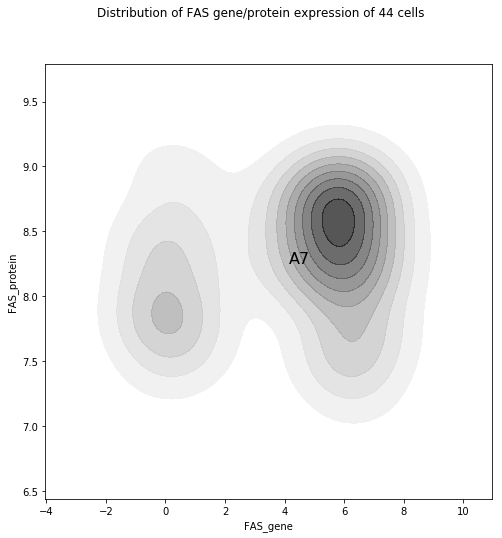

In [19]:
pg_scatter('FAS', clone='A7')

To compare two different clones, we overlay plots.

In [20]:
def pg_pair(pg,clonea, cloneb, ax=None):
    # Two subsets for the two clones.
    pg_df_a = pg_df[ pg_df['Clone_ID'] == clonea] 
    pg_df_b = pg_df[ pg_df['Clone_ID'] == cloneb]

    # Set up the figure
    f, ax = plt.subplots(figsize=(8, 8))
    
    # Draw the two density plots
    ax = sns.kdeplot(pg_df_a[pg+'_gene'], pg_df_a[pg+'_protein'],
                     cmap="Reds", shade=True, shade_lowest=False, alpha=0.7)
    ax = sns.kdeplot(pg_df_b[pg+'_gene'], pg_df_b[pg+'_protein'],
                     cmap="Blues", shade=True, shade_lowest=False, alpha=0.7)

    # Add labels to the plot
    red = sns.color_palette("Reds")[-2]
    blue = sns.color_palette("Blues")[-2]
    
    genemean_a = pg_df_a[pg+'_gene'].mean()
    genemean_b = pg_df_b[pg+'_gene'].mean()
    protmean_a = pg_df_a[pg+'_protein'].mean()
    protmean_b = pg_df_b[pg+'_protein'].mean()
    
    ax.text(genemean_a, protmean_a, clonea, size=16)
    ax.text(genemean_b, protmean_b, cloneb, size=16)
    f.suptitle('Comparison of {} protein/gene expression between {} and {}'.format(pg, clonea, cloneb))
    return ax

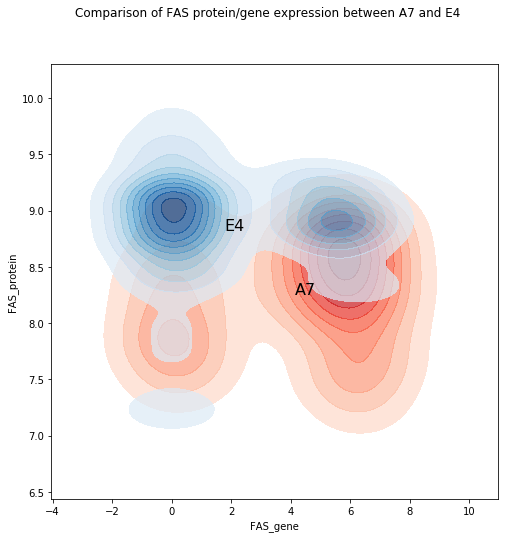

In [21]:
pg_pair('FAS','A7', 'E4')

Note that the "blobs" above zero arise from dropouts -- cells with no detected gene expression.  The above figure shows that E4 clones have significantly more FAS dropouts than A7 clones, but E4 clones (surprisingly?) have higher FAS protein expression.

Now we put together cells of the same clonotype, to compare statistics between clones.

In [22]:
def pg_compare(pg_list, ax=None, col_wrap = 5):
    serieslist = []
    for pg in pg_list:
        pg_df = pd.concat([EM[pg], prolog.loc[EM.index][pg]], axis=1)
        pg_df.columns = ['gene', 'protein'] # Separate headers for gene and protein.
        pg_df['Clone_ID'] = meta_df.loc[EM.index].Clone_ID # Add clonality information.
        pg_df_means = pg_df.groupby('Clone_ID').apply(lambda col : col.mean() )
        pg_df_means['protein and gene'] = pg
        serieslist.append(pg_df_means)
        
    df_means = pd.concat(serieslist, axis=0)
    
    sns.lmplot(x = 'gene', y = 'protein', data = df_means, col = 'protein and gene',
               sharex=False, sharey=False, truncate=True, height=3, ci=95, col_wrap = col_wrap)

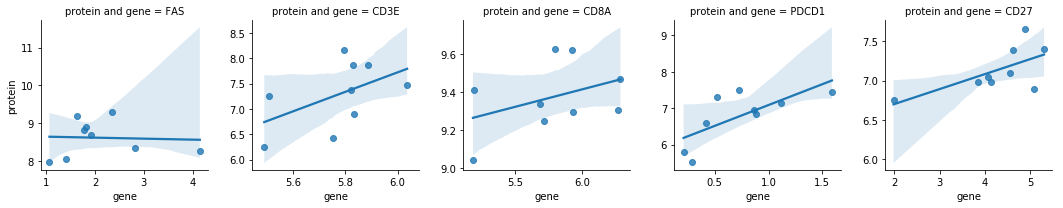

In [23]:
pg_compare(paired_proteins)

Here, each dot represents the mean gene expression and mean protein expression, for a given paired protein/gene and for all cells within a clonotype.  There seems to be a positive correlation between mean gene expression and mean protein expression -- but the 95% confidence intervals are too wide to tell in most cases.  (The P3128 data, with 24 clones, exhibits a stronger correlation between gene expression and protein expression.)

<a id='Signature'></a>
# 3.  Gene expression as a signature of clonality.

A central question is whether gene expression is a "signature" of clonality.  T-cells allow us to study this question because (1) the TCR genes certainly *do* provide a signature of clonality, so we *know* the clonotype of every cell, and (2) excluding the TCR genes, we can examine whether broad gene expression is a signature of this clonotype.  

We take a supervised machine learning approach to this question.  In this approach, a "signature" of clonality means that we can train the computer to predict clonality from gene expression.  We try three different machine learning approaches:

1.  A Bernoulli Naive Bayes (BNB) classifier, using binarized gene expression data.
2.  A Gaussian Naive Bayes (GNB) classifier, using genes which are very frequently expressed (above a cutoff).
3.  A Linear Support Vector (SVC) classifier, using genes selected by ANOVA F-statistic.

The approaches vary in their predictive accuracy, but all classifiers are far better than one would expect by chance.  They also go beyond what one might expect if the classifier was simply distinguishing cell types (e.g. memory vs. effector cells).  The Linear SVC classifier is most accurate, correctly predicting clonotype from gene expression about 95% of the time (using tuned parameters and a 80/20 training/testing split).

Each approach comes with a mode of feature selection and representation that carries additional information.  We study these along the way, to visualize the clonality signatures.

Using scikit-learn, the data is separated into an array `X` of gene expression (the "features") and an array `y` of clonalty (the "classes").  These will later be divided into training and validation sets.

In [24]:
X = EM.copy()  # The features.  Copied in memory, just in case.
y = meta_df.Clone_ID.loc[cells] # We are trying to predict clonality from the features.
y_ct = meta_df.cell_type[cells] # In case we just want to predict MEM/MIX/EFF type.

For comparison to random assignment to clonotypes, i.e. a null hypothesis, we also produce a shuffled list of clonality.

In [25]:
yshuff = pd.Series(np.random.permutation(y.values), index=y.index)

We provide some general-purpose functions for visualizing the results of cross-validation, and for examining the "confusion matrix" of a classifier.

In [26]:
def CV_map(gs, swap=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))

In [27]:
from sklearn import base

def confusion_matrix(X,y,pipe, reps=2, classlist = None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    
    f, ax = plt.subplots(figsize=(8,7))
    sns.heatmap(valid, annot=valid, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Overall prediction accuracy {:0.3%}. \n"
                 "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

Each machine learning approach will be paired with a set of "significant" genes.  To visualize the expression of these genes, we provide a few general-purpose functions here.

In [28]:
def sort_by(df, col, valuelist):
    '''
    Sorts a data frame, according to the values in a column,
    and a chosen order for these values.
    '''
    if set(df[col].unique()) != set(valuelist):
        print('Warning, cannot sort!')
        return df
    value_dict = {valuelist[j]:j for j in range(len(valuelist))}
    df['newcol'] = df[col].apply(lambda v : value_dict[v])
    df.sort_values('newcol', inplace=True)
    df.drop('newcol', axis=1)
    return df

In [48]:
def vis_genebars(ef, mf, genelist, prop, classlist = None, style='z_score', 
                 cutoff = 1.0, genelabels = True, fitlabels = False,
                gene_names = None):
    '''
    Visualizes gene expression across cells.
    
    Args:
        ef (pandas dataframe):  The gene expression matrix.
        mf (pandas dataframe:  The metadata dataframe.
        genelist (list): The list of genes to visualize.
        prop:  A column of the metadata, e.g. Clone_ID.  Place cells in blocks according to this.
        classlist:  Custom sort Clone_ID (or whatever prop) according to this list.
        z_score:  Plot z-scores for each gene.
        binarize:  Plot binarized data, e.g. whether a gene is on or off.
        cutoff:  The cutoff for binarization.
        genelabels:  Label the rows by genes if True.
        fitlabels:  If True, extend the height of the image to fit in all the gene labels.
        
    Returns:
        None.  Just makes a pretty picture.
        
    
    '''
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    
    df[prop] = mf[prop]
    if classlist:
        df = sort_by(df, prop, classlist)
    else:
        df.sort_values(prop, inplace=True)
    
    cells = df.index
    md = mf.loc[cells]
    classes = md[prop].unique()

    # Create plot.
    
    # Adjust height to include labels.
    if fitlabels:
        figheight = len(genelist) // 4
    else:
        figheight = 12
    figsize=(12, figheight)
    
    # Create colors for clones (or whatever classes)
    pal = sns.cubehelix_palette(len(classes),light=.9, dark=.1, reverse=True, start=1, rot=-2)
    lut = dict(zip(classes, pal))
    colors = pd.Series(df[prop]).map(lut)

    title = []
    title.append('Expression for {} genes.'.format(len(genelist)))
    
    if style == 'zscore':
        method,metric = 'average', 'euclidean'
        cg = sns.clustermap(df[genelist].transpose(), z_score=0, cmap="bwr", vmin=-3, vmax=3, 
                            col_colors=colors, figsize=figsize, col_cluster=False,
                           metric=metric, method=method)
        title.append('Color represents z-score.')
        
    elif style == 'binarize':
        method,metric = 'complete', 'hamming'
        cg = sns.clustermap(df[genelist].transpose() > cutoff, cmap="magma", vmin=0, vmax=1.0, 
                            col_colors=colors, figsize=figsize, col_cluster=False,
                            metric = metric, method=method)
        title.append('Binarized gene expression')
        
    figtitle = '\n '.join(title)
    
    cg.ax_row_dendrogram.set_visible(False)
    #cg.ax_col_dendrogram.set_visible(False)
    if style == 'zscore':
        cg.cax.set_position([1.05, .3, .03, .2])
    elif style == 'binarize':
        cg.cax.set_visible(False)
    ax = cg.ax_heatmap
    if not genelabels:
        ax.set_yticks([])
        ax.set_ylabel('')
        ax.set_yticklabels([])
    #cg.ax_col_colors.set_title(figtitle, fontsize=14)
    cg.ax_col_dendrogram.set_title(figtitle, fontsize=14)
    
    for label in classes:
        cg.ax_col_dendrogram.bar(0, 0, color=lut[label],
                                 label=label, linewidth=0)
    cg.ax_col_dendrogram.legend(loc="center", ncol=3)

    #plt.figsize()
    plt.show()

In [57]:
def correlelogram(ef, genelist, binarize=False, z_score = True, cutoff = 1.0, num_genes = False):
    
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    if num_genes and binarize:
        print('Warning:  Number of genes and binarized expression cannot both be plotted by this function.')
    if num_genes:
        df['num_genes'] = (ef[genelist] > cutoff).sum(axis=1)
    if binarize:
        df = df > cutoff
    elif z_score:
        df = df.apply(zscore)
    
    # Cluster and sort genes.
    if zscore:
        method,metric = 'average', 'euclidean'
    elif binarize:
        method,metric = 'complete', 'hamming'   
    Y = sch.linkage(df[genelist].transpose(), method=method, metric=metric)
    genelist_sort = [genelist[j] for j in sch.leaves_list(Y)]

    if num_genes:
        corr_matrix = df[['num_genes'] + genelist_sort].corr()
    else:
        corr_matrix = df[genelist_sort].corr()

    f, ax = plt.subplots(figsize=(18, 12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr_matrix, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

    title = 'Correlations (Pearson r) between expression of {} genes. \n'.format(len(genelist_sort))
    if binarize:
        title += 'Expression binarized with TPM cutoff {0:1.3f}.'.format(np.exp(cutoff)-1)
    elif z_score:
        title += 'Expression z-scores used for comparison.'
    f.suptitle(title)
    plt.show()

## 3.1  Machine learning via naive Bayes

scRNA gene expression data is complicated by dropouts (zeros) of biological and technical origin, some false-identifications (low expression counts which should be zero), and a generally complicated "real" distribution of gene expression in each cell.  A common model is ZINB (zero-inflated negative binomial), which is studied in [Risso et al.](https://www.nature.com/articles/s41467-017-02554-5), for example.

The ZINB model has three parameters (see Methods of loc. cit.), capturing dropout frequency and mean and dispersion (of the negative-binomial distribution).  Our Bayesian approach is a modification, which captures three closely related statistics:  the zero-frequency (zero = below a threshold hyperparameter) and the mean/std of the nonzero expressions.  This approach is computationally simpler (using existing tools) and separates phenomena which may have distinct biological origins.

Our Bayesian approach has two components: 

-  (Type B, for Binarized/Bernoulli) We binarize gene expression -- either a gene is expressed (above a threshold) or not.  We may use binarized gene expression to predict clonotype, choosing the most variable (binarized) genes by a $\chi^2$ statistic.  The hyperparameters are the threshold and the number of genes used for prediction.

- (Type G for Gaussian)  We consider only genes that are frequently expressed (e.g. >90% of cells express the gene).  We use differential expression of such genes to predict clonotype, choosing the most variably-expressed genes by an ANOVA F-statistic.  The hyperparameters are the number of frequently expressed genes in the first pool, and the number of differentially expressed genes used for prediction.

Along the way, we choose "significant" genes for prediction.  We study these genes, visualizing their expression profiles across clones.

### Type B:  The Bernoulli Naive Bayes Pipeline

We create a scikit-learn pipeline with three steps:  binarization, feature selection (selecting genes by a $\chi^2$-statistic), then using a Bernoulli Naive Bayes classifier.  Binarization turns all gene expressions into zeros or ones, depending on whether they reach a threshold. 

In [31]:
BNBpipe = make_pipeline(Binarizer(), SelectKBest(score_func = chi2), BernoulliNB())

To analyze the predictive power, we carry out 5-fold cross-validation on a grid of hyperparameters.  The first hyperparameter is the threshold for gene expression (for binarization).  The second is the number of genes (selected by $\chi^2$-statistic) used for prediction.

In [32]:
## DANGER DANGER.  Ignoring all warnings!
import warnings
warnings.filterwarnings("ignore")
##

param_grid = dict(binarizer__threshold=[0.01, 0.05, 0.075, 0.1, 0.2, 0.5, 1.0, 1.5, 2.0],
                  selectkbest__k = range(10,251,20),
                 )
grid_search = GridSearchCV(BNBpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('binarizer', Binarizer(copy=True, threshold=0.0)), ('selectkbest', SelectKBest(k=10, score_func=<function chi2 at 0x1c1ea89510>)), ('bernoullinb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'binarizer__threshold': [0.01, 0.05, 0.075, 0.1, 0.2, 0.5, 1.0, 1.5, 2.0], 'selectkbest__k': range(10, 251, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The following visualizes the results of cross-validation.

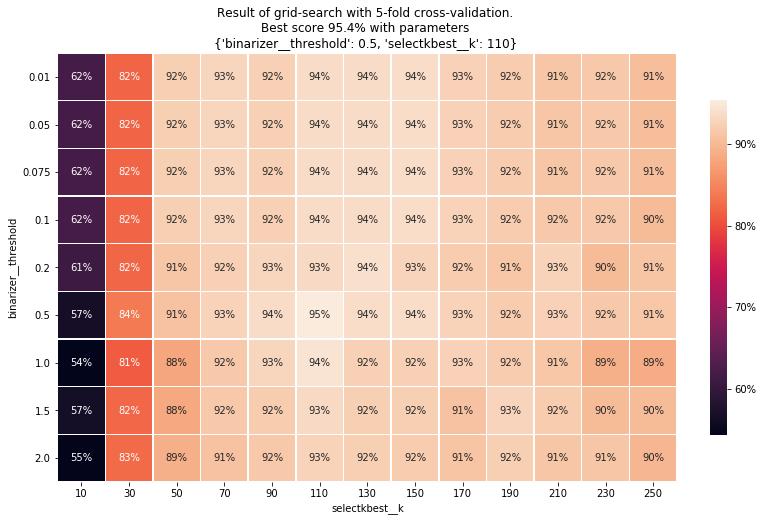

In [33]:
CV_map(grid_search)

We find that *binarized* gene expression data (whether a gene is expressed or not) yields a roughly 91% accurate predictor of clonotype, once hyperparameters are tuned (80-140 genes, with expression cutoff between 0.05 and 1.5).  The optimal hyperparameters are named below.

In [34]:
opt_threshold = grid_search.best_params_['binarizer__threshold']
opt_k = grid_search.best_params_['selectkbest__k']
print('Using tuned threshold {} and number of genes k={}'.format(opt_threshold, opt_k))

Using tuned threshold 0.5 and number of genes k=110


We run our Bernoulli Naive Bayes pipeline to study its predictions in more detail.  The data is divided into training and validation sets, in an 80%/20% ratio.  The classifier is trained on 80% and validated on 20%.  The "confusion matrix" displays the actual class (i.e., clonotype) and predicted class for each cell among the 20% in the validation set.

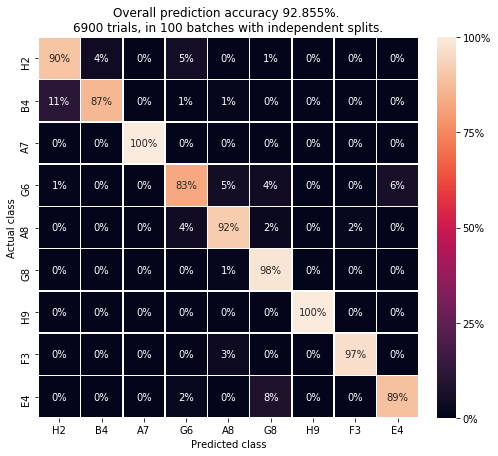

In [35]:
BNBpipe = make_pipeline(Binarizer(threshold=opt_threshold), 
                        SelectKBest(score_func = chi2, k=opt_k), 
                        BernoulliNB())

confusion_matrix(X,y,BNBpipe, reps=100, classlist = clones)

This confusion matrix shows that the MEM clones (B4 and H2) are confused with each other somewhat frequently, but rarely with the MIX or EFF clones.  Similarly, the EFF clones (G6, A8, G8, H9, F3) are very rarely confused with the MEM clones.  Among the other two, the A7 clones are almost never confused with others, while the E4 clones are confused with EFF clones about 18% of the time.

Next, we visualize binarized gene expression as a "barcode" of clonality.  We select the top 150 genes, by $\chi^2$ statistic after binarization.  Gene expression is binarized, so bars display whether or not a gene is expressed.  Genes are hierarchically clustered, using hamming-distance and the "complete method" described in the [SciPy documentation](https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.cluster.hierarchy.linkage.html).  Cells are organized into clones, and clones are organized from EFF (first 5 color-bars) to MEM (next 2 color-bars) to MIX (last 2 color-bars).

The top 150 genes, selected by chi2 statistic after binarization, are RP11-465B22.3, PER3, RP3-477M7.5, ID3, STMN1, CEP85, MAP3K6, KIAA0319L, IFI44L, S1PR1, CSF1, REG4, SLAMF7, FCGR3A, SELL, GLUL, RGS16, C1orf21, RGS1, FAIM3, AKR1C3!0, KIAA1217, ZWINT, MKI67, IFITM1, NUCB2, CD82, AHNAK, SMCO4, CADM1, AMICA1, MPZL2, FEZ1, CD9, KLRG1, KLRB1, CLECL1, CLEC7A, KLRD1, KLRC3, KLRC2, KLRC1, RP11-291B21.2, STYK1, RP11-493L12.5, RP11-81H14.2, PMCH, OAS1, LPAR6, RCBTB2, TC2N, ASB2, PATL2, SHC4, KIAA0101, NPTN, CTSH, ISG20, IDH2, LRRC28, PRSS21, HIRIP3, SHCBP1, MT2A, COTL1, CCL23, CCL3L3!0, CCL4L1!1, CCL4L2, HOXB2, CD300A, TK1, BIRC5, LGALS3BP, ZBTB32, GNG8, LAIR2!1, NCR1!7, RSAD2, RRM2, FAM49A, PRKCE, EPAS1, PLEK, CAPG, IL18RAP, PAX8-AS1, BIN1, SLC4A10, CD28, CCL20, MIR155HG, MX1, USP18, GGT1, MCM5, DESI1, EOMES, CXCR6, CCR1, CCR2, C3orf14, RPL38P4, GPR15, CD200R1, SKIL, RPL39L, CCDC50, LYAR, STAP1, HPGD, GZMK, SPOCK1, TIMD4, SOX4, LTA!5, HLA-DRA!2, HLA-DRB5, HLA-DRB6, HLA-DQB1!0, HLA-DPA1!1, CDK

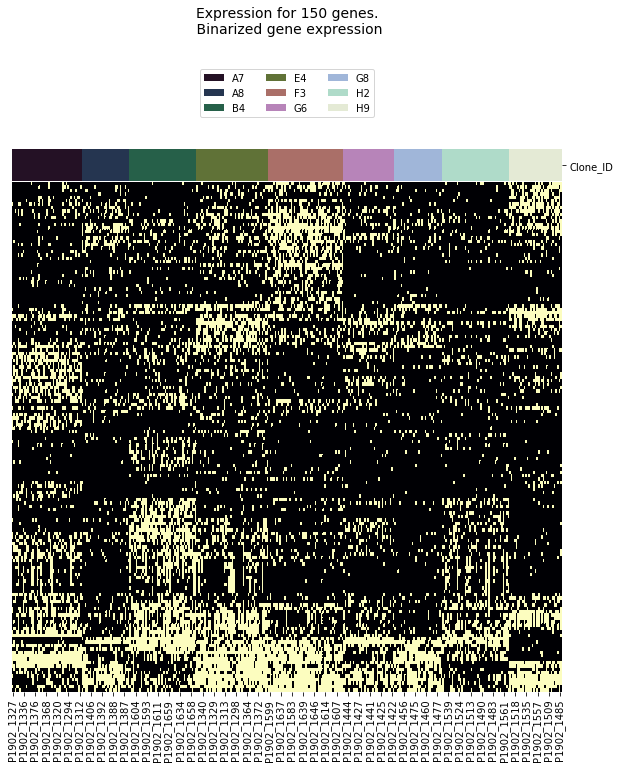

In [49]:
selector = make_pipeline(Binarizer(threshold=opt_threshold), 
                        SelectKBest(score_func = chi2, k=150))

selector.fit(X,y)
skb = selector.named_steps['selectkbest']
selected_genes = list(compress(genes, skb.get_support()))

print('The top 150 genes, selected by chi2 statistic after binarization, are {}.'.format(', '.join(selected_genes)))

df = EM[selected_genes].copy()
vis_genebars(df, meta_df, selected_genes, 'Clone_ID', style='binarize', genelabels=False,
             cutoff = opt_threshold)

For later use, we create a dataframe of genes, together with their $\chi^2$ statistic and associated p-value after binarization.  Genes with low p-value are those whose dropout frequency exhibits statistically significant variability between clones.

In [37]:
selector = make_pipeline(Binarizer(threshold=opt_threshold), 
                        SelectKBest(score_func = chi2, k='all'))

selector.fit(X,y)
skb = selector.named_steps['selectkbest']
selected_genes = list(compress(genes, skb.get_support()))

onoff_genes = pd.DataFrame(index=selected_genes, columns=['chi2', 'p_value'])
onoff_genes.chi2 = list(compress(skb.scores_, skb.get_support()))
onoff_genes.p_value = list(compress(skb.pvalues_, skb.get_support()))
onoff_genes.sort_values('p_value', inplace = True)

The ten most significant on/off genes are below.

In [38]:
display(onoff_genes[:10])

,chi2,p_value
PLS3!0,161.147049,9.205697e-31
REG4,155.952999,1.121475e-29
LRRC28,116.421827,1.814476e-21
TIMD4,110.406152,3.141629e-20
CCL20,108.350578,8.307810e-20
GPR15,107.660917,1.151017e-19
LGALS3BP,104.904887,4.230641e-19
RP3-477M7.5,99.088435,6.555401e-18
SLAMF7,88.983587,7.477319e-16
CD300A,87.630029,1.406560e-15


In [39]:
print('There are {} genes, which exhibit statistically significant (p<0.01)  ' 
      'variability in dropout rate between clones.  In order of p-value, they are {}.'.format(
          len(onoff_genes[ onoff_genes.p_value < 1e-2]), 
          ', '.join(onoff_genes[ onoff_genes.p_value < 1e-2].index)
      ))

There are 721 genes, which exhibit statistically significant (p<0.01)  variability in dropout rate between clones.  In order of p-value, they are PLS3!0, REG4, LRRC28, TIMD4, CCL20, GPR15, LGALS3BP, RP3-477M7.5, SLAMF7, CD300A, ID3, ANXA1, CD40LG, RP11-465B22.3, RPL38P4, MIR155HG, CD200R1, AMICA1, CADM1, GNG8, KLRG1, LAIR2!1, CCL23, SAMD3, KLRB1, STMN1, FAM49A, STEAP1, SELL, DOCK5, S1PR1, PER3, IFI44L, KLRC2, KLRC3, NCR1!7, EPAS1, CCDC50, ASB2, RGS1, CCR2, AOAH, C1orf21, SRRT, LAT2!0, KLRD1, PDE7B, UBA52P5, CTSL, PLEK, FCGR3A, PRKCE, CXCR6, CSF1, EOMES, GZMK, IL18RAP, RP11-291B21.2, RCBTB2, CLEC7A, CD9, MX1, PMCH, SHC4, SOX4, LTA!5, CAPG, MT-TI, PAX8-AS1, SPOCK1, HLA-DRB6, RRM2, USP18, MKI67, ISG20, CDKN2B, KIAA0101, CLIC3, MT2A, HLA-DRB5, KLRC1, HLA-DPA1!1, GLUL, MPZL2, TK1, AKR1C3!0, LPAR6, NUCB2, CDKN1A, CTSH, IFITM1, ZBTB32, HLA-DQB1!0, C3orf14, ZWINT, PTPRN2, CCL4L2, RUNX2, TC2N, CD28, KIAA1217, CLECL1, DESI1, PATL2, HPGD, MLLT4, SGK1, SLC4A10, RP11-493L12.5, LINC00861, KIAA0319L,

### Type G:  The Gaussian Naive Bayes Pipeline.

Now we carry out a similar analysis using a Gaussian Naive Bayes classifier.  The general purpose visualizers are the same as before.

The pipeline has three steps:

1.  Selecting only genes which are frequently expressed (above a TPM=10 threshold).
2.  From this pool, select the genes whose expression levels vary most between classes.
3.  Train the Gaussian Naive Bayes classifier on these selected genes.

Step 1 requires a custom scoring for frequency of expression.  Step 2 uses an ANOVA F-statistic for scoring (which is built in).

In [40]:
def express_score(X,y, threshold = 10):
    '''
    Scoring a gene based on frequency of expression.
    Default threshold is log-transform of a raw count of 10.  log(10+1) = 2.4
    '''
    return np.array((X>np.log1p(threshold)).sum(axis=0))

In [41]:
GNBpipe = Pipeline([ ('expr',SelectKBest(express_score, k=500)), 
                    ('fval',SelectKBest(f_classif, k=100)), 
                    ('gnb',GaussianNB()) ]) 

We carry out 5-fold cross-validation on a grid of hyperparameters.  The two hyperparameters are the number of genes in the pool of *frequently* expressed genes, and the number of genes in the subpool of *differentially* expressed genes.  These are called `expr__k` and `fval__k`, respectively.

In [42]:
param_grid = dict(expr__k = range(200,1001,50), fval__k = range(10,161,10))
grid_search = GridSearchCV(GNBpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('expr', SelectKBest(k=500, score_func=<function express_score at 0x1c233f1840>)), ('fval', SelectKBest(k=100, score_func=<function f_classif at 0x1c1ea89400>)), ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'expr__k': range(200, 1001, 50), 'fval__k': range(10, 161, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The results of cross-validation are displayed below, along with the optimal hyperparameters.

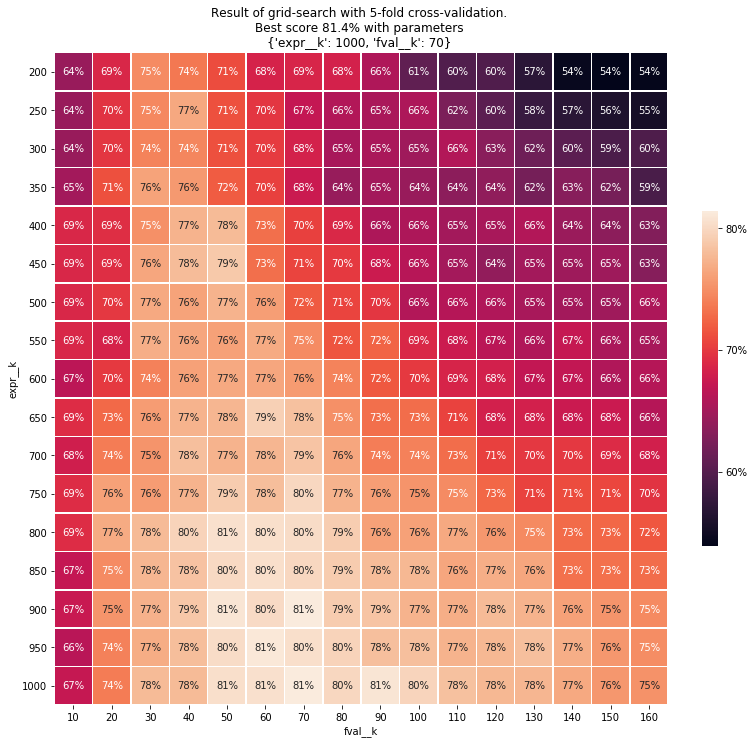

In [43]:
CV_map(grid_search)

The cross-validation indicates that it might be advantagous to keep more genes in the initial pool (selected by frequency of gene expression).  But in this circumstance, dropouts play a much larger role, and we wish to restrict our analysis to genes which are frequently expressed for now.  Thus we choose a non-optimal value (450) for `expr__k`, since we wish to limit our attention to the genes which are very frequently expressed.

We create a confusion matrix, to study the predictions in more detail. 

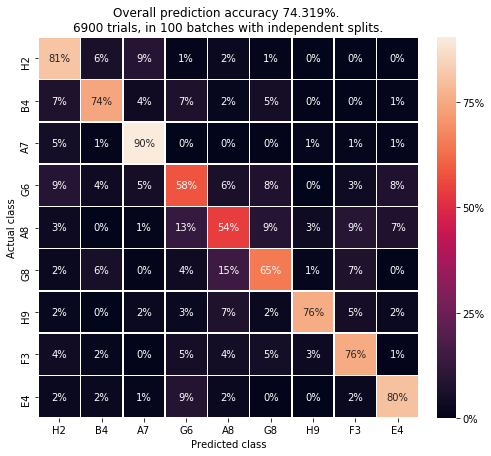

In [44]:
opt_expr__k = 450
opt_fval__k = 40
GNBpipe = Pipeline([ ('expr',SelectKBest(express_score, k=opt_expr__k)), 
                    ('fval',SelectKBest(f_classif, k=opt_fval__k)), 
                    ('gnb',GaussianNB()) ]) 

confusion_matrix(X,y,GNBpipe, reps=100, classlist = clones)

A similar pattern arises in this classification method, as with the binarized/Bernoulli approach.  There is more confusion within the MEM clones and within the EFF clones than there is *between* MEM and EFF clones.  The A7 clones are rarely confused with others.

Now we select the 200 most frequently expressed genes for the starting pool, and then select the 50 most variably expressed genes (by ANOVA F-statistic) among the 200. We use the expression level of these 50 genes to produce a "gene expression barcode," to visualize this signature of clonality.

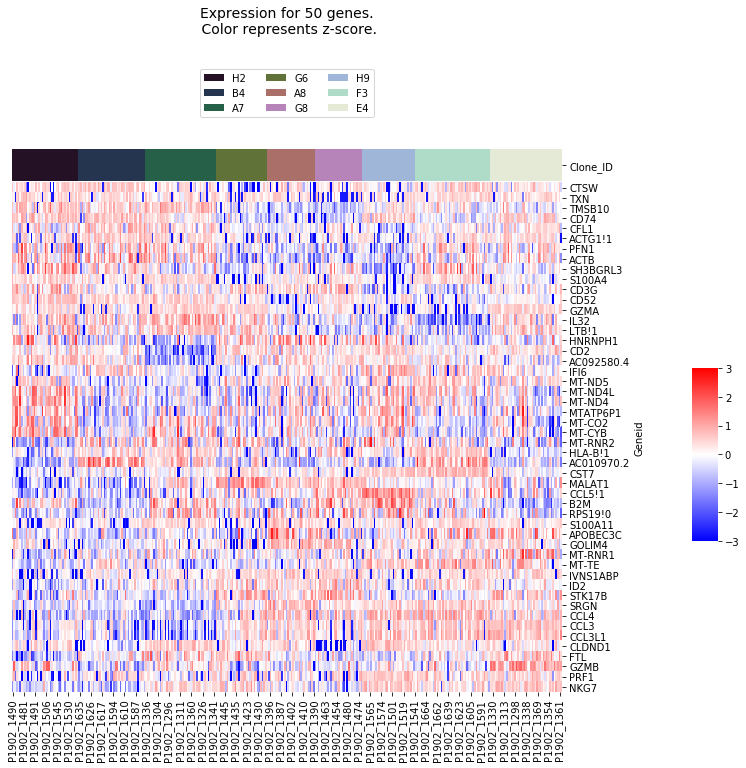

In [50]:
selector = Pipeline([ ('expr',SelectKBest(express_score, k=200)), 
                    ('fval',SelectKBest(f_classif, k=50))]) 

selector.fit_transform(X,y)
skbe = selector.named_steps['expr']
skbf = selector.named_steps['fval']

exp_genes = list(compress(genes, skbe.get_support())) # frequently expressed genes.
selected_genes = list(compress(exp_genes, skbf.get_support()))

df = EM[selected_genes].copy()
vis_genebars(df, meta_df, selected_genes, 'Clone_ID', style='zscore', classlist=clones)

For later use, we create a dataframe of "tunable" genes.  These are genes which are very *frequently* expressed, but whose expression level varies significantly between clones.

In [53]:
selector = Pipeline([ ('expr',SelectKBest(express_score, k=100)), 
                    ('fval',SelectKBest(f_classif, k='all'))]) 

selector.fit_transform(X,y)
skbe = selector.named_steps['expr']
skbf = selector.named_steps['fval']

exp_genes = list(compress(genes, skbe.get_support())) # frequently expressed genes.
selected_genes = list(compress(exp_genes, skbf.get_support()))

tunable_genes = pd.DataFrame(index=exp_genes, columns=['nonzero_ratio', 'p_value'])
tunable_genes.nonzero_ratio = list(compress(skbe.scores_, skbe.get_support())) 
tunable_genes = tunable_genes.loc[selected_genes]
tunable_genes.p_value = list(compress(skbf.pvalues_, skbf.get_support()))
tunable_genes.nonzero_ratio = tunable_genes.nonzero_ratio / np.float64(len(X))
tunable_genes.sort_values('p_value', inplace = True)
# Print the ten most significant genes.
display(tunable_genes[:10])

,nonzero_ratio,p_value
AC010970.2,1.000000,9.387533e-46
CD2,0.991304,1.465427e-37
IL32,1.000000,9.346843e-36
MALAT1,1.000000,5.261949e-30
B2M,1.000000,2.486751e-28
CD74,0.973913,2.452977e-25
CCL4,0.976812,8.384037e-25
CCL5!1,1.000000,1.779145e-23
FTL,0.997101,1.164973e-21
ACTB,1.000000,8.261390e-21


In [54]:
print('We study {} frequently expressed genes.'.format(len(tunable_genes)))
print('Their maximum dropout rate is {0:2.1%}'.format(1 - tunable_genes.nonzero_ratio.min()))

We study 100 frequently expressed genes.
Their maximum dropout rate is 4.9%


In [55]:
print('Among these genes, {} vary significantly (p < 0.01) between clones.'.format(
    len(tunable_genes[ tunable_genes.p_value < 1e-2])))
print('These genes, ordered by p-value, are: {}'.format(', '.join(tunable_genes[ tunable_genes.p_value < 1e-2].index)))


Among these genes, 72 vary significantly (p < 0.01) between clones.
These genes, ordered by p-value, are: AC010970.2, CD2, IL32, MALAT1, B2M, CD74, CCL4, CCL5!1, FTL, ACTB, NKG7, SH3BGRL3, SRGN, AC092580.4, LTB!1, TMSB10, APOBEC3C, GZMB, CD3G, MT-TE, MT-CYB, CD52, MT-CO2, ID2, STK17B, HNRNPH1, MT-ND4L, CST7, HLA-B!1, PFN1, MT-ND4, IFI6, RPS19!0, MT-RNR2, MTATP6P1, MT-RNR1, MT-ND5, CFL1, TMSB4XP8, MT-ATP6, MT-CO1, HLA-A!1, CAPZA1, MT-TP, ARHGDIB, TMSB4X, MYL6, CD3D, TMSB4XP1, FTH1, H3F3B, RPS27, ATP5E, MT-ATP8, EIF5A, CALM1, GNLY, MT-CO3, PPP1CB, PTPRC!1, EEF1A1, C6orf62, MYL12A, C16orf54, RPL7, RPL31, HLA-C!1, RPL21, RPS26, SRP14, RPL18A, SERF2


 The clustering of genes exhibits some correlations in expression.  We create a correlation matrix below, and visualize gene-to-gene correlations in expression.  The number of genes is also included, so that we can see which higher-than-average gene expressions may be related to normalization issues.  For example, by carrying out TPM normalization at the beginning, those cells which express a large number of genes may have appear to have lower gene expressions (so that total expression per cell adds up to one million).
 
We focus here on the genes which exhibit significant variability at the $p < 10^{-6}$ level between clones.

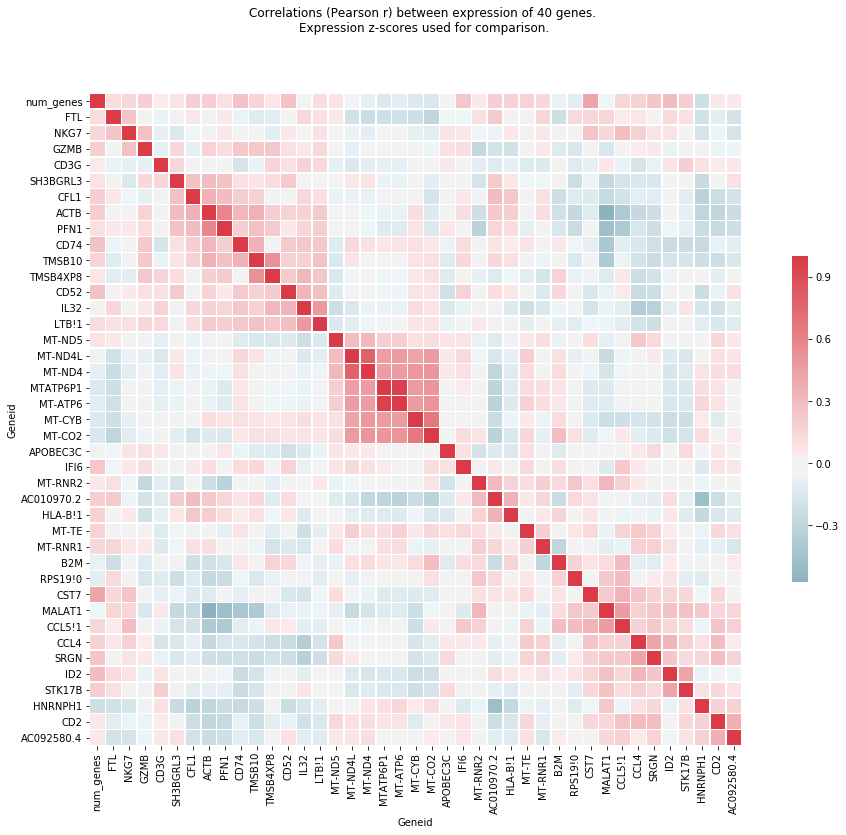

In [58]:
correlelogram(EM, tunable_genes[ tunable_genes.p_value < 1e-6].index, num_genes = True)

## 3.2:  Machine learning by linear SVM

Next, we take an entirely different approach to classification, using a soft-margin linear support vector classifier (SVC).  Support vector machines have been applied successfully in other genomic contexts -- see [Huang et al.](https://dx.doi.org/10.21873%2Fcgp.20063) for a survey in the context of cancer classification.  Our linear SVC pipeline has three steps.

1.  We pre-process the data by applying a linear function -- all gene-expressions will be shifted and scaled to lie between 0 and 1.  This is standard practice for linear SVM.

2.  We select the most variable genes by ANOVA F-statistic.  

3.  We apply the LinearSVC classifier and study the chosen genes.

4.  The LinearSVC classifier chooses weighted combinations of genes (we call these *metagenes*) that most effectively separate clones.  We study these weighted combinations in more detail and visualize them as signatures of clonality.

Regarding gene selection in step 2, we also attempted recursive feature elimination (RFE) with cross-validation.  This iteratively removes low-weighted genes from the metagenes, to select the genes most important for prediction.  While this might lead to improved classification with tuning, it did not make a big difference and it is computationally much more intensive.  On the other hand we do consider the weights of genes at the end, to better understand the selected metagenes.

We use 5-fold cross-validation and a grid search on the two most important hyperparameters.  These hyperparameters are the number of genes used in the classifier, and the C-parameter for the SVM.  In LinearSVC, the classifier tries to separate clonotypes by hyperplanes in gene-expression space.  Hyperplanes are scored by two criteria:

1.  Hyperplanes are considered better when the samples are farthest away from them (size of margin).

2.  Samples on the "wrong" side of the hyperplane count against the score, proportionally to how far on the wrong side they lie.  The C-parameter determines the penalty for these badly located samples, i.e., a higher C-parameter will be less tolerant of samples on the wrong side of the hyperplane.

In [59]:
#  DANGER DANGER!  The lines below ignore all warnings.
#  It's nice to avoid all the convergence warnings.  
#  But dangerous in general.
import warnings
warnings.filterwarnings("ignore")
#  End of warning.... proceed below.

SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=2000)) ])

param_grid = dict(skb__k = range(25,301,25), svm__C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('mm', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=110, score_func=<function f_classif at 0x1c1ea89400>)), ('svm', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'skb__k': range(25, 301, 25), 'svm__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

We visualize the cross-validation results as before.

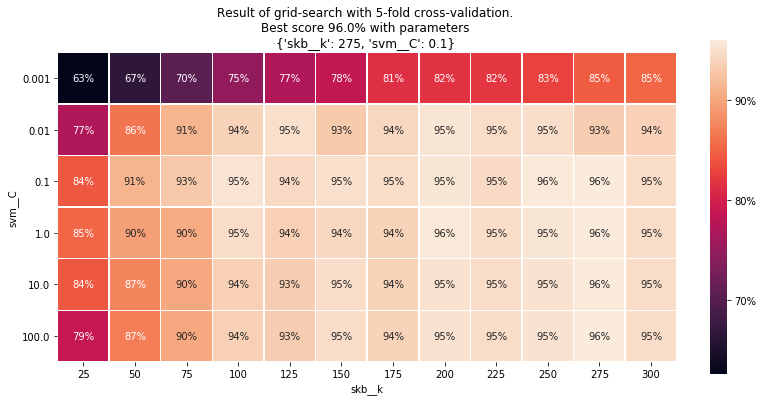

In [60]:
CV_map(grid_search, swap=True)

With minimal tuning, the SVM classifier (LinearSVC) exhibits better predictive accuracy than either of the Naive Bayes classifiers.  On the P1902 data, the SVM classifier achieves around 95% accuracy with 100-300 genes and a wide range of C-parameters.  The performance is excellent across a broad swath of parameters.  At least 50 genes seem necessary for achieving 90% accuracy in clonotype prediction.

This might be as good as it gets, though one could try other classifiers (e.g. neural net) just to see.  Next, we look at the confusion matrix, with tuned paramaters.

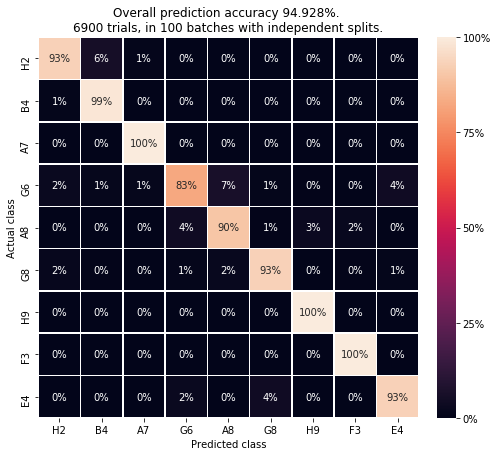

In [61]:
opt_skb__k = grid_search.best_params_['skb__k']
opt_svm__C = grid_search.best_params_['svm__C']

SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=opt_skb__k)),
                     ('svm', LinearSVC(C = opt_svm__C)) ])

confusion_matrix(X,y,SVM_pipe, reps=100, classlist = clones)

Confusion is very rare, and exhibits the same pattern of MEM/EFF/MIX distinction as the other classifiers.  The E4 clones are never confused with MEM clones, but are occasionally confused with EFF clones. 

### Examination of "metagenes"

The first step in our SVM pipeline is the selection of significant genes, based on ANOVA F-statistic.  Note that we don't do any other filtering -- frequency of expression is not separately accounted for.  All we are looking at is the variation of gene-expression means among groups... and zeros will certainly affect these means!  Also, we are applying the F-statistic on non-normally distributed data.  We leave it to the statisticians to decide whether this is naughty.

We look at the 50 most significant genes, selected by this process.  Then, the support vector classifier attempts to separate the clones by considering weighted averages of these genes.  We describe these weighted averages, and visualize them as a signature of clonality.

In [62]:
SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=50)),
                     ('svm', LinearSVC(C = 0.1)) ])

SVM_pipe.fit(X,y)
skbf = SVM_pipe.named_steps['skb']
lsvc = SVM_pipe.named_steps['svm']

diff_genes = list(compress(genes, skbf.get_support())) # differentially-expressed genes by ANOVA F
print('The {} differentially expressed genes (selected by ANOVA F) are: {}'.format(len(diff_genes),', '.join(diff_genes)))

The 50 differentially expressed genes (selected by ANOVA F) are: RP3-477M7.5, ID3, CSF1, CD2, REG4, SLAMF7, IL2RA, IFITM1, MALAT1, CADM1, AMICA1, LAG3, KLRB1, KLRD1, KLRC3, KLRC2, KLRC1, IFNG, ALOX5AP, B2M, LRRC28, IL32, CCL5!1, CCL3, CCL4, CCL3L3!0, CCL4L1!1, CCL3L1, CCL4L2, LGALS3BP, FTL, LAIR2!1, PLEK, MIR155HG, CXCR6, RPL38P4, GPR15, CD74, TIMD4, HLA-DRB5, SAMD3, PDGFA, ACTB, GIMAP4, DOCK5, ANXA1, MT-TN, PLS3!0, CD40LG, AC010970.2


In [63]:
def make_metagene(coef_list, g_list):
    '''
    Represents SVC coefficients as a metagene, including both coefficients and genes.
    Metagenes are represented as Python dictionaries, with keys=genes, values=coefficients.
    '''
    return dict(zip(g_list, coef_list))

The linear support vector machine creates certain linear combinations of gene expressions, which are then used to classify clones.  We call these linear combinations *meta-genes* and study them below.

In [64]:
metagenes = [ make_metagene(coef_list, diff_genes) for coef_list in lsvc.coef_ ]

In [65]:
def display_weighted(metagene, cutoff = 0.1):
    '''
    Displays a list of coefficients as a weighted average of gene expressions.
    Displays only those genes which contribute above a cutoff to the weighted average.
    '''
    term_list = []
    cno = 0
    for gene in metagene.keys():
        coef = metagene[gene]
        if abs(coef) > cutoff:
            if coef >= 0:
                if cno > 0:
                    sgn_mark = ' + '
                else:
                    sgn_mark = ''
            else:
                sgn_mark = ' - '
            term = '{0:} {1:0.3f} {2:}'.format(sgn_mark, abs(coef), gene)
            term_list.append(term)
            cno += 1
    return ''.join(term_list) + '... (+ terms with coefficient < {})'.format(cutoff)      

In [66]:
mg_no = 0
for metagene in metagenes:
    mg_no += 1
    print('METAGENE {}: '.format(mg_no), display_weighted(metagene))
    print('---------------------------')

METAGENE 1:   -  0.222 RP3-477M7.5 +  0.214 ID3 -  0.350 CD2 +  0.312 SLAMF7 -  0.159 IL2RA -  0.161 CADM1 -  0.486 AMICA1 -  0.221 LAG3 +  0.303 KLRD1 +  0.467 KLRC3 +  0.191 KLRC2 -  0.191 KLRC1 +  0.115 IFNG -  0.128 LRRC28 -  0.195 CCL5!1 -  0.176 CCL3 -  0.108 CCL3L3!0 -  0.156 CCL4L1!1 -  0.145 CCL3L1 -  0.166 CCL4L2 -  0.186 LAIR2!1 +  0.195 PLEK -  0.175 MIR155HG -  0.347 CXCR6 -  0.256 TIMD4 +  0.366 SAMD3 +  0.128 GIMAP4 +  0.391 ANXA1 -  0.149 PLS3!0 +  0.198 AC010970.2... (+ terms with coefficient < 0.1)
---------------------------
METAGENE 2:   0.451 CSF1 -  0.117 CD2 -  0.179 REG4 -  0.153 SLAMF7 -  0.395 IFITM1 +  0.104 MALAT1 +  0.183 CADM1 -  0.286 LAG3 -  0.155 KLRD1 -  0.132 KLRC2 -  0.279 KLRC1 +  0.461 ALOX5AP -  0.404 B2M +  0.242 LRRC28 +  0.148 IL32 -  0.171 CCL5!1 +  0.157 CCL3L3!0 +  0.177 CCL4L1!1 -  0.162 CCL4L2 -  0.227 LAIR2!1 +  0.175 PLEK +  0.344 MIR155HG +  0.372 CXCR6 -  0.215 RPL38P4 -  0.149 GPR15 -  0.473 CD74 -  0.569 TIMD4 -  0.389 SAMD3 -  0.282

Now, we turn this around, and examine the genes which contribute to the metagenes.  Each metagene is a weighted combination of (up to 50) genes.  We select the genes whose contribution is above a cutoff to some metagene.

In [67]:
def under_genes(mg_list, cutoff = 0.1):
    '''
    Gets the most significant genes appearing in a list of metagenes.
    Significance is determined by weight, according to a cutoff.
    '''
    ug_set = set([])
    for mg in mg_list:
        for gene in mg.keys():
            if abs(mg[gene]) > cutoff:
                ug_set.add(gene)
    return ug_set

In [68]:
print('The following genes underlie the metagenes: {}.'.format(', '.join(under_genes(metagenes)) ) )

The following genes underlie the metagenes: B2M, CCL5!1, CADM1, KLRD1, SAMD3, PLS3!0, IFITM1, KLRC2, KLRB1, KLRC3, AC010970.2, GPR15, PLEK, KLRC1, RP3-477M7.5, IFNG, FTL, IL32, MIR155HG, CXCR6, CCL3L1, CD74, LAG3, LGALS3BP, CCL3, IL2RA, HLA-DRB5, MALAT1, CCL4L1!1, LAIR2!1, TIMD4, SLAMF7, AMICA1, CD2, ANXA1, REG4, CD40LG, PDGFA, GIMAP4, LRRC28, ID3, CCL3L3!0, ACTB, RPL38P4, MT-TN, ALOX5AP, DOCK5, CSF1, CCL4, CCL4L2.


Now we visualize the metagene-expression profile of our clones.  First, we create a dataframe with the metagene expression levels.

In [69]:
def add_metas(df, mg_list, mg_names='auto'):
    if type(mg_list) != list: # For adding single metagene.
        mg_list = [mg_list]
    mgname_list = []
    for j in range(len(mg_list)):
        if mg_names == 'auto':
            mg_name = 'Metagene {}'.format(j+1)
        else:
            mg_name = mg_names[j]
        mgname_list.append(mg_name)
        mg = mg_list[j]
        df[mg_name] = sum( (mg[gene]*df[gene] for gene in mg.keys() ))
    if mg_names == 'auto':
        return df, mgname_list
    else:
        return df

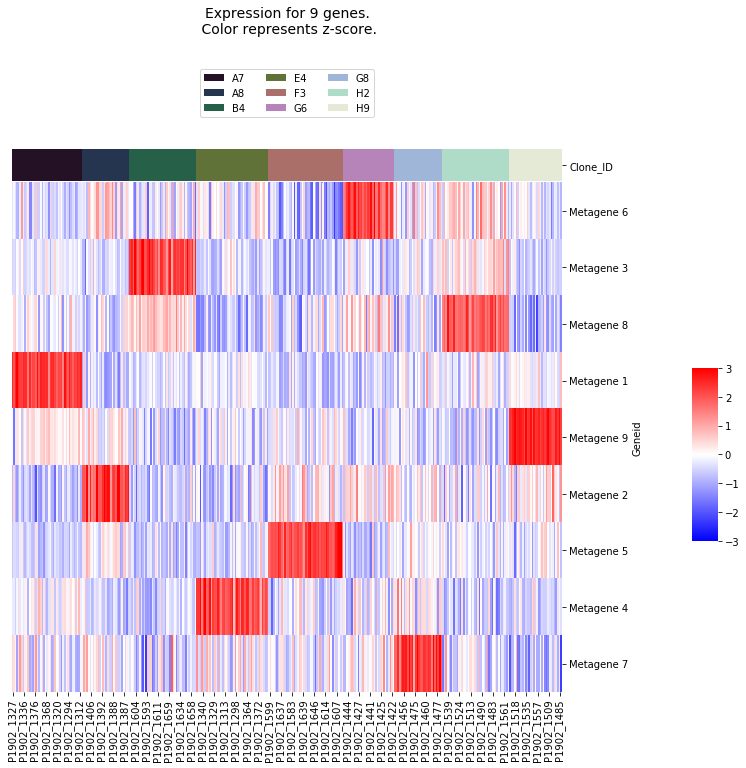

In [70]:
df = EM[diff_genes].copy()
df, metagene_list = add_metas(df, metagenes)
vis_genebars(df, meta_df, metagene_list, 'Clone_ID', style='zscore')

In the figure above, we have used all of the cells in fitting the support vector classifier.  The resulting metagenes are overfitted as a result.  But separation into training/testing sets still leads to an excellent classifier.  The illustration above is meant to show *how* linear combinations of variably-expressed genes (our "metagenes") distinguish the clones.  And by fitting on all of the cells, the metagenes may carry better biological information.  The genes whose weights are the largest in the metagenes are those which are most significant for distinguishing clones.

Metagenes are also well-suited for scRNA data with a large proportion of dropouts.  By summming up contributions from many genes (with weights), the dropout-noise has a smaller effect without imputation.

As a way of checking the metagenes, we look at their expressions on the *bulks*.  We load the bulk metadata here.

In [81]:
meta_bulks = pd.read_pickle('P1902_meta_bulks.pkl') # Load metadata from a pickle.
meta_bulks.Clone_ID.unique()

array(['E4', 'A7', 'H2', 'B4'], dtype=object)

The metagenes that isolate these four clones are Metagenes 1,3,4,8.  (Or numbers 0,2,3,7 in Pythonic numbering).

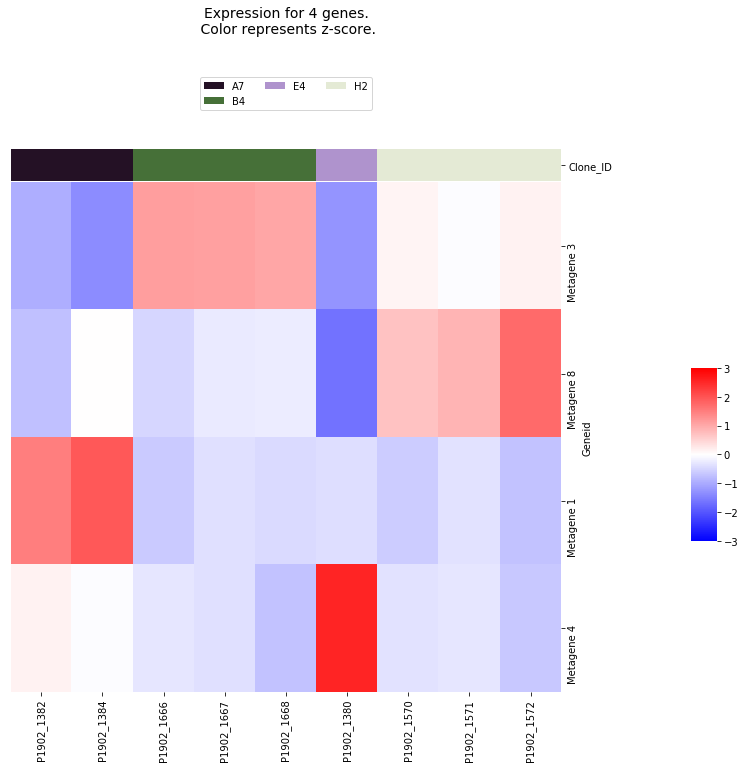

In [88]:
df = EM_bulks[diff_genes].copy()
df, metagene_list = add_metas(df, metagenes)
metagenes_bulks = [metagene_list[j] for j in [0,2,3,7]]
vis_genebars(df, meta_bulks, metagenes_bulks, 'Clone_ID', style='zscore')

Thus the metagenes can distinguish the bulks too.  Metagene 1 isolates the A7 bulks, Metagene 3 isolates the B4 bulks, Metagene 4 the E4 bulk, and Metagene 8 the H2 bulks.

Now we plot gene expression for the single cells, using the most significant (highly-weighted) genes occurring within the metagenes.

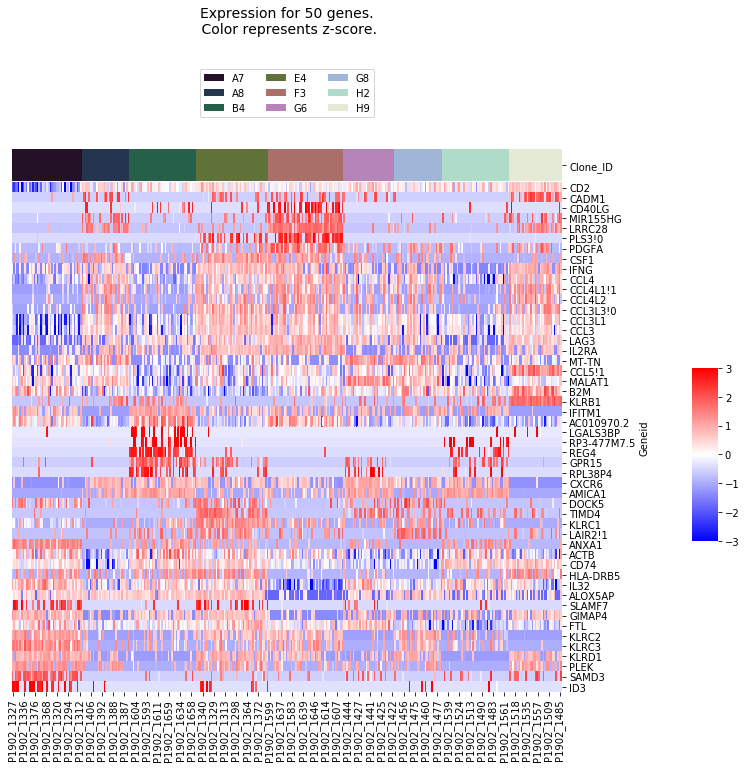

In [89]:
vis_genebars(EM, meta_df, list(under_genes(metagenes, cutoff=0.1)), 'Clone_ID', style='zscore')

Weighted combinations of these genes (the metagenes) do an excellent job of distinguishing clones, by "averaging out" the noise.  Still, one can see "blockiness" in the above picture, indicating the clonal specificity of the expression of these genes.  Some exhibit more binary behavior, and can be found in the earlier Bernoulli Naive Bayes approach.  Others are more "tunable" and can be found in the Gaussian Naive Bayes approach.

It seems like a good idea to try out the metagene approach when clone labels are shuffled.  This addresses a possible criticism -- that with 8000-ish genes, one should be able to find *some* linear combinations to distinguish arbitrary groups of 40-ish cells.  So let's run the pipeline again with shuffled labels.

In [90]:
SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=50)),
                     ('svm', LinearSVC(C = 0.1)) ])

SVM_pipe.fit(X,yshuff)
skbf = SVM_pipe.named_steps['skb']
lsvc = SVM_pipe.named_steps['svm']

diff_genes_shuff = list(compress(genes, skbf.get_support())) # differentially-expressed genes by ANOVA F
print('The {} differentially expressed genes (selected by ANOVA F) are: {}'.format(
    len(diff_genes_shuff),', '.join(diff_genes_shuff)))

The 50 differentially expressed genes (selected by ANOVA F) are: PARP1, C1orf131, CAMK2G, GRK5, BCCIP, CELF1, CD3D, LAG3, CLSTN3, NECAP1, RP11-96H19.1, USP15, MIR16-1, TGDS, KLHL28, SERF2, ISG20, C16orf13, TMEM199!1, CEP95!0, C17orf80, CCDC137, MRPL12, ELP2, CTB-31O20.2, MOB3A, MRPL54, PLEKHF1, SEPW1, ADA, RTFDC1, TUSC2!1, VPRBP!1, HTT, SMIM15, F2R, REEP5, UQCRQ, BTN3A2, ZSCAN16, MRPS18B!3, SAYSD1, SNX14, BUD31, KCTD9, DPY19L4, OXR1, PHF19, RP11-357C3.3!0, SEPT6


In [91]:
metagenes_shuff = [ make_metagene(coef_list, diff_genes_shuff) for coef_list in lsvc.coef_ ]

In [92]:
mg_no = 0
for metagene in metagenes_shuff:
    mg_no += 1
    print('METAGENE {}: '.format(mg_no), display_weighted(metagene))
    print('---------------------------')

METAGENE 1:   -  0.178 GRK5 +  0.284 BCCIP -  0.150 CELF1 -  0.188 CD3D +  0.336 LAG3 -  0.195 CLSTN3 -  0.445 NECAP1 +  0.417 USP15 -  0.422 MIR16-1 -  0.443 TGDS -  0.416 SERF2 +  0.196 C16orf13 -  0.353 CEP95!0 -  0.324 C17orf80 +  0.190 CCDC137 +  0.288 MRPL12 -  0.238 CTB-31O20.2 -  0.206 MOB3A +  0.172 MRPL54 +  0.510 PLEKHF1 +  0.117 SEPW1 +  0.299 ADA +  0.102 RTFDC1 +  0.161 TUSC2!1 -  0.210 VPRBP!1 -  0.222 HTT -  0.200 SMIM15 -  0.210 UQCRQ -  0.365 BTN3A2 -  0.162 ZSCAN16 -  0.302 MRPS18B!3 -  0.109 SAYSD1 -  0.337 SNX14 -  0.229 BUD31 +  0.164 OXR1 +  0.357 PHF19 +  0.308 RP11-357C3.3!0 +  0.205 SEPT6... (+ terms with coefficient < 0.1)
---------------------------
METAGENE 2:   0.212 BCCIP +  0.132 CELF1 -  0.108 CD3D +  0.174 NECAP1 +  0.270 TGDS -  0.359 KLHL28 -  0.478 SERF2 -  0.239 ISG20 -  0.108 C16orf13 +  0.133 TMEM199!1 -  0.109 CEP95!0 +  0.112 MRPL12 -  0.164 ELP2 -  0.276 MOB3A -  0.297 MRPL54 -  0.128 RTFDC1 -  0.196 VPRBP!1 +  0.325 HTT +  0.107 F2R +  0.253 

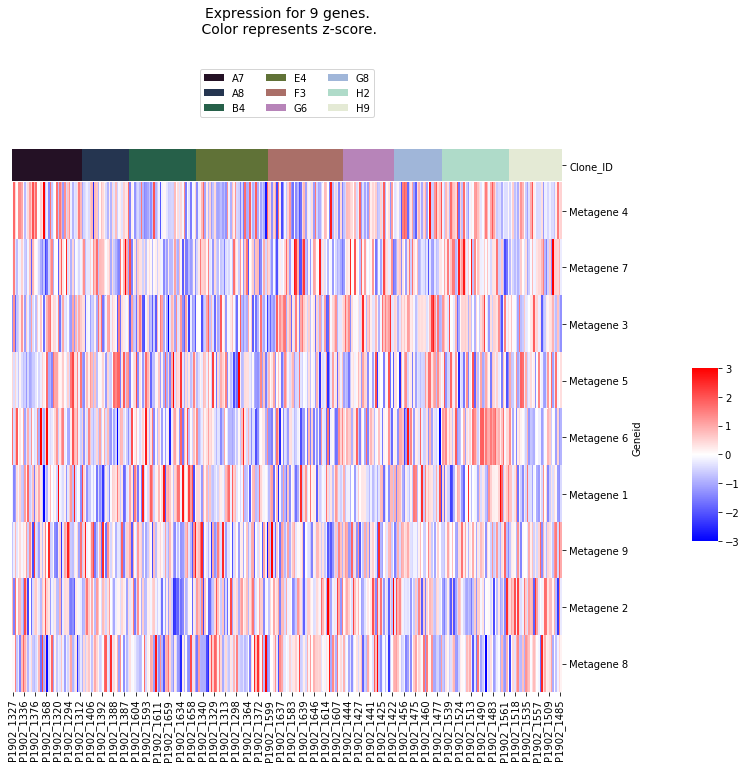

In [93]:
df = EM[diff_genes_shuff].copy()
df, metagene_list = add_metas(df, metagenes_shuff)
vis_genebars(df, meta_df, metagene_list, 'Clone_ID', style='zscore')

This null-hypothesis experiment certainly does not yield a nice family of metagenes!

<a id='DGE'></a>
# 4.  Differential gene expression

Here we explore differential gene expression among clones, bewteen and within traditional EFF/MEM cell types.  We take a nonparameteric approach here, based on the Kruskal-Wallis H-statistic.  The specific questions we have are the following:

1.  Is a gene XYZ expressed differently by different clones?
2.  If so, do the clonal differences in expression of XYZ primarily reflect the EFF/MEM status of the clone?
3.  Or, does the expression of XYZ distinguish one clone from all the others?

For the second and third questions, we go a bit under-the-hood in the H-statistic, apply some permutation tests, etc.

For more on differential expression analysis in scRNA data, see [Soneson and Robinson, Nature Methods volume 15, pages 255–261 (2018)](https://www.nature.com/articles/nmeth.4612).  They compare 36 approaches to identifying differentially expressed genes.  It would be interesting to apply our method to their data set to compare performance.

Seurat, by default, uses the Wilcoxon ranked sum test for identifying differentially expressed genes, with the Bonferroni correction for multiple groups (I think).  Note that Kruskal-Wallis H is analogous to Wilcoxon, but designed for multiple groups (rather than corrected for them).  For practical purposes, I think that our H-approach is the same as Seurat's default.

We import some more functions for this analysis.  This includes the new [scikit-posthocs package](https://github.com/maximtrp/scikit-posthocs).

In [97]:
import matplotlib.colors as pcolors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import mpl_toolkits.axes_grid1.colorbar as colorbar
import scipy.stats as ss
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

import scikit_posthocs as sp

### General purpose visualizations

In order to inspect a single gene's varying expression among the clones, the following function makes a swarm-plot, and gives the ANOVA F-statistic and Kruskal-Wallis H-statistic.

In [107]:
def swarm_gene(gene, clip = False, zshow = False):
    df = EM.copy()
    df['Clone_ID'] = meta_df.Clone_ID
    H = ss.kruskal(*[group[gene].values for name, group in df.groupby('Clone_ID')])
    F = ss.f_oneway(*[group[gene].values for name, group in df.groupby('Clone_ID')])
    df['num_genes'] = (EM[genes] > 2.4).sum(axis=1)
    
    df = df[[gene, 'Clone_ID', 'num_genes']]
    if clip:
        df = df[ df[gene] > 2.4 ] # Clip dropouts.
    df['z_genes'] = zscore(df['num_genes'])
    
    #create a figure
    fig,ax = plt.subplots(figsize=(9,6))
    
    # Apply a colormap.
    if zshow:
        cmap = plt.get_cmap("viridis")
        norm = pcolors.Normalize(vmin=df['z_genes'].min(), vmax=df['z_genes'].max())    
        df['zc'] = df['z_genes'].apply(lambda cval : cmap(norm(cval)))
    
    # Create the swarmplot
    if zshow:
        sns.swarmplot(x='Clone_ID', y=gene, data=df, hue = 'z_genes', 
                      palette=df['zc'], order=clones)
    else:
        sns.swarmplot(x='Clone_ID', y=gene, data=df, order=clones)
    
    ax.set_ylabel('Expression of {}, log-scale.'.format(gene))

    # create colorbar ##
    if zshow:
        plt.gca().legend_.remove()
        divider = make_axes_locatable(plt.gca())
        ax_cb = divider.new_horizontal(size="5%", pad=0.15)
        fig.add_axes(ax_cb)
        cb1 = colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=norm, orientation='vertical')
        cb1.ax.set_ylabel('z-score of number of genes expressed')

    title_lines = ['Differential expression of {0} among clones.'.format(gene)]
    title_lines.append('Kruskal-Wallis H-statistic {0:3.3f}, p-value {1:1.3e}.'.format(H.statistic, H.pvalue))
    title_lines.append('ANOVA F-statistic {0:3.3f}, p-value {1:1.3e}.'.format(F.statistic, F.pvalue))
    fig.suptitle('\n '.join(title_lines))
    plt.show()

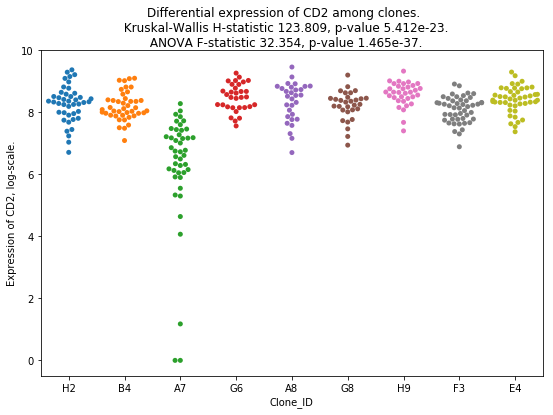

In [108]:
swarm_gene('CD2')

In this visualization of the differential expression of CD2, we see that A7 expresses the gene at lower levels than the other clones (with a few dropouts too).  Each dot stands for a cell.  Statistics for differential expression (Kruskal-Wallis H and ANOVA F) are included in the title.

### Non-parameteric approach, via Kruskal-Wallis

Our first function creates a data frame, the "KW-frame" whose rows are the clones and whose columns are the genes.  The entries are terms whose squares sum to the Kruskal-Wallis H-statistic.  Namely, if $h_{ij}$ is the entry for gene $i$ and clone $j$, then the Kruskal-Wallis H-statistic of gene $i$ is given by 
$$H = \sum_{j = 1}^g h_{ij}^2.$$
(Here $g$ is the number of clones.)  The entries of the KW-frame may be used later.

In [100]:
def KW_frame(gf, mf, prop = 'Clone_ID', genelist = None):
    if genelist:
        gf_rank = gf[genelist].rank()
    else:
        gf_rank = gf.rank()
    
    # Each column of gf_rank is a number between 1 and N.
    # N is the number of cells.
    N = len(gf_rank)
    meanrank = (1+N)/2 # Mean of all the ranks. 
    gf_rank[prop] = mf[prop] # Add the clonotype (or prop) to dataframe.
    pops = gf_rank[prop].value_counts() # Populations
    
    gf_rankmean = gf_rank.groupby(prop).apply(np.mean) # Compute mean ranks, the \bar r_i.
    
    ties = gf_rank.apply(lambda col : ss.tiecorrect(col))
    scaling = 12 / (ties * N*(N+1))
    H_frame = (gf_rankmean - meanrank).mul(np.sqrt(pops), axis=0)
    H_frame = H_frame * np.sqrt(scaling)
    return H_frame

Computing the KW-frame will take a minute or so.

In [101]:
EM_KW = KW_frame(EM, meta_df)
display(EM_KW)

Geneid,AAAS,AAED1,AAGAB,AAK1,AAMP,AAR2,AARS,AASDHPPT,AATF,ABC7-42389800N19.1!2,...,ZSWIM8,ZUFSP,ZWILCH,ZWINT,ZYX,ZZEF1,ZZZ3,hsa-mir-6723,snoU13!301,snoU13!420
A7,-0.309613,0.725018,0.293891,0.851536,-0.813435,0.068950,-1.120220,0.896960,0.535764,1.907932,...,0.456573,0.819313,0.257736,2.534656,0.646545,0.637128,0.377919,0.526819,-0.272644,-2.301926
A8,-0.324707,-0.165045,0.966656,-0.793604,-0.165743,1.119614,-0.317584,-0.480738,-0.153613,0.783981,...,-0.578751,-1.189637,-1.630033,-2.469649,-0.239621,-0.344598,-0.957265,0.437545,-0.244052,-0.754930
B4,2.528656,-0.046496,1.714162,0.179336,-0.313696,1.711021,1.730196,0.217365,1.864077,0.994876,...,0.483393,-0.277563,2.991023,3.977538,2.078357,-0.364048,-0.122581,1.436622,1.716152,1.634842
E4,-0.407152,0.826521,1.079878,1.682309,-0.863433,0.940598,-0.114361,0.062910,1.297300,-0.570708,...,1.155857,0.156897,0.184678,1.648485,0.320155,0.033641,0.155268,1.155469,1.788200,-1.745567
F3,0.673257,-1.464530,-2.211387,1.874991,2.017972,-0.931260,2.594543,-0.480315,0.746435,-0.491459,...,-0.960588,-0.392180,-0.242147,-2.359905,-0.321971,1.502244,0.934747,-0.533862,-1.236160,1.930049
G6,0.351825,-1.504292,-0.449501,-2.122356,0.061027,-1.367865,0.129307,-0.344639,-0.593830,0.538449,...,1.023404,1.067290,-0.128481,-2.550643,-0.399577,2.052708,0.149797,-3.063936,1.093478,0.029662
G8,-1.623537,-1.245541,-2.180908,1.022773,1.540707,0.528281,-1.483687,0.138904,-2.098993,-1.423918,...,-1.562355,-0.538044,-1.088699,-2.469649,-1.893977,-1.685535,0.215949,0.614210,-0.902834,1.533930
H2,-0.238491,1.580872,0.668750,-1.949386,-2.746321,-1.198291,-0.940114,-0.740141,-1.554043,-0.777340,...,0.656771,-0.141734,-0.050976,2.574256,0.720061,-1.468856,-0.062653,-1.021959,-1.007043,-0.610292
H9,-1.043045,1.040704,-0.049182,-1.317094,1.620359,-0.869281,-0.970527,0.719107,-0.641600,-1.115617,...,-0.983167,0.408072,-0.822376,-2.205719,-1.465439,-0.585697,-0.964959,0.226047,-1.081346,0.465260


We use this to compute the Kruskal-Wallis H-statistics and associated p-values for every gene.

In [102]:
H = (EM_KW**2).sum(axis=0)
pvals =  ss.distributions.chi2.sf(H, len(clones) - 1)
H_frame = pd.DataFrame.from_dict({'H' : H, 'pvalue':pvals})
H_frame = H_frame.sort_values('pvalue') # Sort by p-value.
H_frame[:10]

,H,pvalue
Geneid,,
REG4,225.268910,2.964544e-44
LRRC28,208.027113,1.297747e-40
AMICA1,190.053906,7.933944e-37
PLS3!0,184.450695,1.195755e-35
AC010970.2,176.468539,5.674821e-34
ANXA1,170.834122,8.623125e-33
CXCR6,159.393765,2.141432e-30
KLRC3,158.567530,3.187381e-30
CD74,158.024341,4.139734e-30


The most significantly (by H-statistic p-value) differentially expressed gene is REG4.  To examine it more closely, we look at the swarm plot.  This also gives a check that the H-statistic and p-value are correct (since they were computed by different methods).

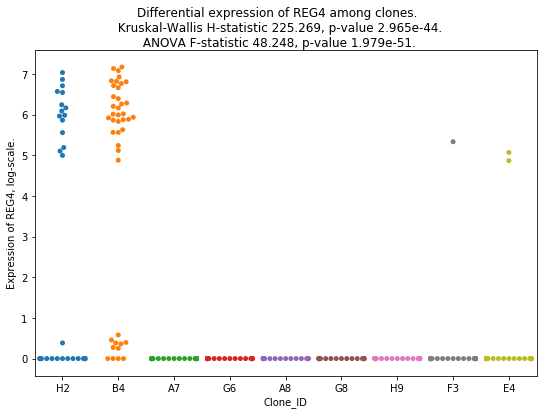

In [109]:
swarm_gene('REG4')

The behavior of REG4 is reflected in the contributions of each clone to the Kruskal-Wallis statistic.  Consider the high values of B4 and H2 in the data below, and compare to the high expression levels of B4 and H2 in the swarm-plot above.

In [111]:
EM_KW['REG4']

A7    -2.930784
A8    -2.420016
B4    12.869756
E4    -2.252103
F3    -2.666107
G6    -2.499381
G8    -2.420016
H2     3.803515
H9    -2.538134
Name: REG4, dtype: float64

LINC-genes might be interesting, so here we list the LINC genes among the significant ones.

In [112]:
H_frame.loc[[gene for gene in H_frame.index if gene[:4] == 'LINC']].head()

,H,pvalue
Geneid,,
LINC00861,56.880541,1.900011e-09
LINC00892,48.154149,9.231251e-08
LINC00152,34.555529,3.221096e-05
LINC01160,32.687091,7.011737e-05
LINC00484,32.353708,8.048674e-05


Here is a swarm-plot of a significant LINC gene.

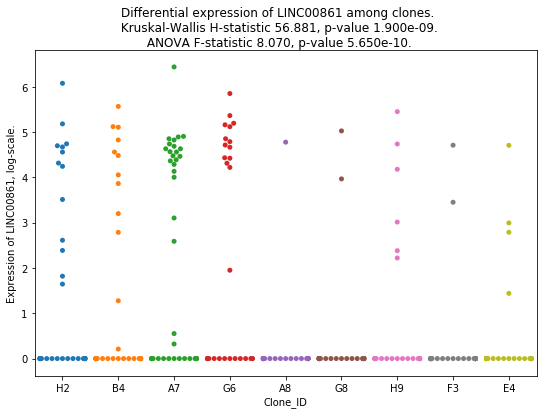

In [113]:
swarm_gene('LINC00861')

Now we look at the genes which are differentially expressed at the p<1e-6 (0.000001) level.  We'll examine the validity of these p-values a bit later.

In [114]:
pcut = 1e-6
genes_H = H_frame[ H_frame.pvalue < pcut].index
print('There are {} H-DE genes with p < {}.'.format(len(genes_H), pcut))

There are 341 H-DE genes with p < 1e-06.


We visualize the expression of these H-DE genes, by z-score as before.  Note that there are too many genes to label.

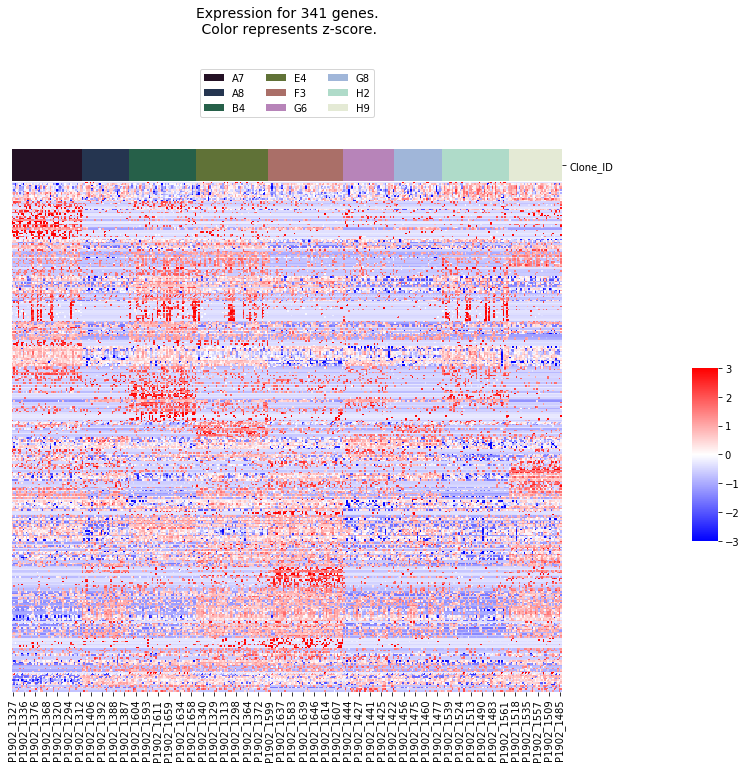

In [115]:
vis_genebars(EM, meta_df, genes_H, 'Clone_ID', style='zscore', genelabels = False)

Since there wasn't space for labels, here is a list of genes portrayed in the above heatmap.

In [117]:
print('The {} H-DE genes, in order of p-value, are: {}.'.format(len(genes_H), ', '.join(genes_H)))

The 341 H-DE genes, in order of p-value, are: REG4, LRRC28, AMICA1, PLS3!0, AC010970.2, ANXA1, CXCR6, KLRC3, CD74, TIMD4, KLRC2, CCL4L1!1, KLRD1, NKG7, GPR15, TMSB10, SRGN, MALAT1, LGALS3BP, B2M, IL32, LAG3, CST7, KLRC1, CCL3L1, PLEK, KLRB1, ALOX5AP, LAIR2!1, CCL4, CD2, CADM1, IL2RA, FTL, CCL3, CCL20, IFITM1, MT-TN, MIR155HG, CCL5!1, MAF, LTB!1, CCL3L3!0, IFNG, CD52, CD40LG, SAMD3, ADAM19, CCL4L2, RP3-477M7.5, FAM49A, S100A4, GZMA, DOCK5, MT-TE, AC092580.4, PDGFA, TMSB10P1, CD200R1, STK17B, RDH10, GIMAP4, ACTB, SLAMF7, HLA-DRB5, ASB2, SH3BGRL3, RP11-465B22.3, CSF1, CCR2, CLDND1, STMN1, ID3, EOMES, SELL, RPL38P4, CCL23, GNG8, TMSB4X, GZMB, CD300A, FCGR3A, AOAH, MX1, EPAS1, S1PR1, LTA!5, SRRT, NDFIP2, HLA-B!1, ID2, NPTN, XBP1, IFI44L, TMSB4XP8, MT-CYB, HLA-DPA1!1, ISG20, MT-CO2, RCBTB2, KLRG1, APOBEC3C, STEAP1, GOLIM4, NCR3!1, CTSL, LPAR6, CD3G, MKI67, LAT2!0, LRRN3, IFI6, CTSW, PER3, LGALS1, CD82, COTL1, ITM2A, RGS1, HLA-DRB6, SHC4, CD9, SKIL, GIMAP7, NCR1!7, HLA-DQB1!0, PDE7B, CMTM6, U

In [120]:
genes_H_notinnate = [gene for gene in genes_H if gene not in genes_innate]
print('The {} non-innate H-DE genes are: {}'.format(len(genes_H_notinnate), ', '.join(genes_H_notinnate)))

The 271 non-innate H-DE genes are: REG4, LRRC28, AMICA1, PLS3!0, AC010970.2, ANXA1, TIMD4, CCL4L1!1, NKG7, GPR15, TMSB10, SRGN, MALAT1, LGALS3BP, CST7, CCL3L1, PLEK, ALOX5AP, LAIR2!1, CADM1, FTL, MT-TN, MIR155HG, CCL5!1, MAF, LTB!1, CCL3L3!0, SAMD3, ADAM19, RP3-477M7.5, FAM49A, S100A4, DOCK5, MT-TE, AC092580.4, PDGFA, TMSB10P1, STK17B, RDH10, GIMAP4, ACTB, ASB2, SH3BGRL3, RP11-465B22.3, CLDND1, STMN1, ID3, EOMES, RPL38P4, CCL23, GNG8, TMSB4X, AOAH, EPAS1, S1PR1, LTA!5, SRRT, NDFIP2, HLA-B!1, ID2, XBP1, TMSB4XP8, MT-CYB, HLA-DPA1!1, MT-CO2, RCBTB2, APOBEC3C, STEAP1, GOLIM4, NCR3!1, CTSL, LPAR6, MKI67, LAT2!0, LRRN3, IFI6, CTSW, PER3, LGALS1, COTL1, ITM2A, RGS1, HLA-DRB6, SHC4, SKIL, GIMAP7, NCR1!7, HLA-DQB1!0, PDE7B, UBA52P5, HLA-DMA!4, NUCB2, MT-TF, CRIM1!0, HNRNPH1, PAX8-AS1, EMP3, CORO1A, CCDC50, IFITM2, RRM2, LY6E, CDKN1A, SENP7, ACTG1!1, MT-ND4L, MT-ND5, SPOCK1, HLA-DRA!2, RP11-81H14.2, PRKCE, KIAA0101, MT-TI, MT-ND4, MT2A, CFL1, FXYD5, IVNS1ABP, C1orf21, TC2N, SGK1, TMSB4XP1, PFN1

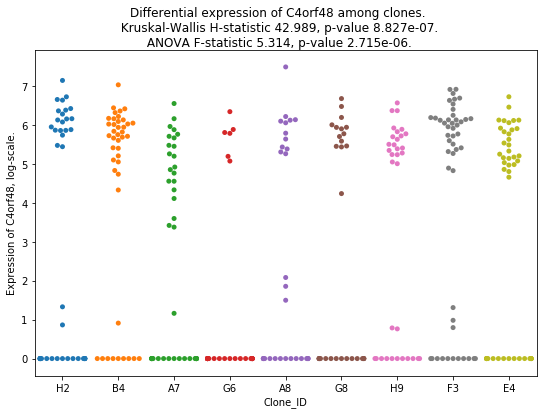

In [125]:
swarm_gene('C4orf48', clip=False)

## Permutation testing on ranked gene expression

The Kruskal-Wallis test is a nonparametric test for differences between groups.  Conceptually, I think of it as an ANOVA on ranks, i.e., every value is converted to a rank, and then ANOVA is run on the ranks for each group.  Ties are resolved in a typical way.  Getting a p-value out of the KW test relies on comparison to a $\chi^2$ distribution, and this is not so clearly "correct" to me.  So we perform the KW test after some permutations of the clone-labels to check this out.  The resulting shuffled KW-frames will be useful for other purposes too.

The following will take a few minutes (maybe 10-15 minutes for 20 shuffles).

In [127]:
num_shuff=20
EM_KW_shuff = [0]*num_shuff
for j in range(num_shuff):
    meta_df_shuff = meta_df.loc[EM.index].copy()
    cloneshuff = pd.Series(np.random.permutation(meta_df_shuff['Clone_ID'].values), index=meta_df_shuff.index)
    meta_df_shuff['Clone_ID'] = cloneshuff
    EM_KW_shuff[j] = KW_frame(EM, meta_df_shuff)
    print('Shuffle {} out of {} complete'.format(j, num_shuff))

Shuffle 0 out of 20 complete
Shuffle 1 out of 20 complete
Shuffle 2 out of 20 complete
Shuffle 3 out of 20 complete
Shuffle 4 out of 20 complete
Shuffle 5 out of 20 complete
Shuffle 6 out of 20 complete
Shuffle 7 out of 20 complete
Shuffle 8 out of 20 complete
Shuffle 9 out of 20 complete
Shuffle 10 out of 20 complete
Shuffle 11 out of 20 complete
Shuffle 12 out of 20 complete
Shuffle 13 out of 20 complete
Shuffle 14 out of 20 complete
Shuffle 15 out of 20 complete
Shuffle 16 out of 20 complete
Shuffle 17 out of 20 complete
Shuffle 18 out of 20 complete
Shuffle 19 out of 20 complete


Now we use the clone-shuffled KW-frames to compute p-values for each gene.

In [129]:
H_frame_shuff = pd.DataFrame(index=EM_KW_shuff[0].columns)
for j in range(num_shuff):
    H_shuff = (EM_KW_shuff[j]**2).sum(axis=0)
    pvals_shuff =  -np.log10(ss.distributions.chi2.sf(H_shuff, len(clones) - 1))
    H_frame_shuff['logpvalue_'+str(j)] = pvals_shuff
H_frame_shuff.head()

,logpvalue_0,logpvalue_1,logpvalue_2,logpvalue_3,logpvalue_4,logpvalue_5,logpvalue_6,logpvalue_7,logpvalue_8,logpvalue_9,logpvalue_10,logpvalue_11,logpvalue_12,logpvalue_13,logpvalue_14,logpvalue_15,logpvalue_16,logpvalue_17,logpvalue_18,logpvalue_19
Geneid,,,,,,,,,,,,,,,,,,,,
AAAS,0.412445,0.198144,0.612921,0.954788,1.190497,0.146092,0.062819,0.240522,0.043341,0.170086,1.654421,0.026044,0.253804,0.402512,0.652146,0.370681,1.143392,0.525134,2.194228,0.206302
AAED1,0.852691,0.036759,0.212646,0.061374,0.246803,0.347710,1.044550,0.037046,0.194238,0.124595,0.404890,0.545564,1.101159,0.097200,1.257927,0.081983,0.752306,0.186598,0.062530,0.028610
AAGAB,0.378528,0.134321,0.286542,0.155599,0.136010,0.411492,0.573106,0.065030,0.582084,0.169880,0.027761,0.338366,1.624448,0.321511,0.246170,0.097622,0.412710,0.194810,2.134228,0.353893
AAK1,0.515004,0.894437,0.266722,0.317326,1.105379,0.141363,0.091777,0.243109,0.351941,0.656173,0.569591,0.939184,0.062263,0.158076,0.361464,0.140079,0.204921,0.662461,0.105456,0.323747
AAMP,0.053784,0.660529,0.030896,0.179113,0.882823,0.183936,0.993112,0.452428,0.120705,0.232890,0.088936,1.325347,0.153122,0.374852,0.282785,0.134882,0.204696,0.241844,0.468573,0.200258


Since the clone labels have been randomly shuffled, the number of genes with p < 0.01 should be approximately 1/100 the sample size (number of genes).

In [134]:
print('The number of genes is {}'.format(len(genes)))
print('We expect {} genes differentially expressed at a p<0.01 level, by chance.'.format(len(genes) / 100))
for j in range(5):
    print('In shuffle {}, we find {} DE genes at p<0.01 level'.format(j,(H_frame_shuff['logpvalue_'+str(j)] > 2).sum()))

The number of genes is 7405
We expect 74.05 genes differentially expressed at a p<0.01 level, by chance.
In shuffle 0, we find 74 DE genes at p<0.01 level
In shuffle 1, we find 46 DE genes at p<0.01 level
In shuffle 2, we find 58 DE genes at p<0.01 level
In shuffle 3, we find 72 DE genes at p<0.01 level
In shuffle 4, we find 77 DE genes at p<0.01 level


The KW p-values are looking pretty good, based on the permutation test.

Now we use the permutation test to determine the number of genes which carry clonal information.  More specifically, we determine the number of differentially expressed genes in the real data, by looking at genes with p<0.01, in *excess* of those one would find by chance.  We show this visually first.

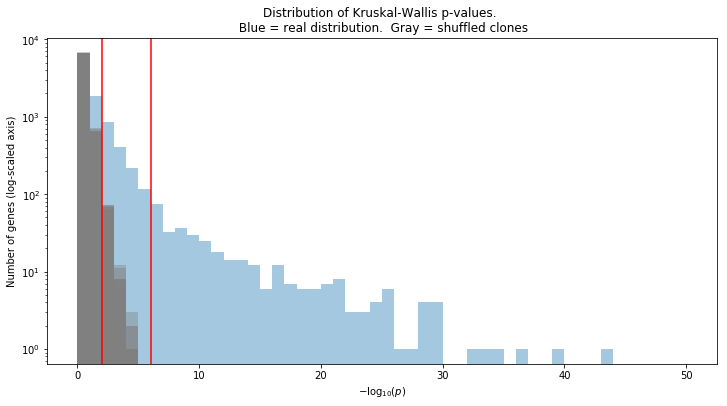

In [136]:
fig,ax = plt.subplots(figsize=(12,6))
g = sns.distplot(-np.log10(H_frame['pvalue']), kde=False, bins=np.linspace(0,50,51))
for j in range(num_shuff):
    sns.distplot(H_frame_shuff['logpvalue_'+str(j)], kde=False, color='gray', bins=np.linspace(0,50,51))
#sns.distplot(mi_eff['Shuffle_0'][mi_eff['Shuffle_0'] > 0.1], kde=False, color='gray', bins=np.linspace(0.1,0.6,26))

plt.xlabel('$- \log_{10}(p)$')
plt.ylabel('Number of genes (log-scaled axis)')
plt.title('Distribution of Kruskal-Wallis p-values. \n Blue = real distribution.  Gray = shuffled clones')
ax.axvline(x=2, color='red')
ax.axvline(x=6, color='red')
g.set_yscale('log')
plt.show()

Now we count the genes with p<0.01, in excess of those expected by chance.

In [151]:
excess_DEGs = (-np.log10(H_frame.pvalue) > 2).sum() - (H_frame_shuff > 2).sum().mean()
print('{} excess genes with p<0.01'.format(excess_DEGs))

1871.5 excess genes with p<0.01


## Analysis of high/low expressors of each gene.

We have computed the KW-frames for 20 permutations of clone labels.  In addition to finding the differentially expressed genes (>1800 genes at p<0.01), we can find which clones are high or low expressors of these genes.  For this, we look at which clones have KW-scores higher/lower than one finds among all 20 permutations of clone-labels. 

Here are the KW scores, for reference.  Low numbers correspond to low expression and high numbers to high expression -- these numbers are based on the *ranked* data, and their squared-sum gives the Kruskal-Wallis H-statistic.

In [161]:
EM_KW

Geneid,AAAS,AAED1,AAGAB,AAK1,AAMP,AAR2,AARS,AASDHPPT,AATF,ABC7-42389800N19.1!2,...,ZSWIM8,ZUFSP,ZWILCH,ZWINT,ZYX,ZZEF1,ZZZ3,hsa-mir-6723,snoU13!301,snoU13!420
A7,-0.309613,0.725018,0.293891,0.851536,-0.813435,0.068950,-1.120220,0.896960,0.535764,1.907932,...,0.456573,0.819313,0.257736,2.534656,0.646545,0.637128,0.377919,0.526819,-0.272644,-2.301926
A8,-0.324707,-0.165045,0.966656,-0.793604,-0.165743,1.119614,-0.317584,-0.480738,-0.153613,0.783981,...,-0.578751,-1.189637,-1.630033,-2.469649,-0.239621,-0.344598,-0.957265,0.437545,-0.244052,-0.754930
B4,2.528656,-0.046496,1.714162,0.179336,-0.313696,1.711021,1.730196,0.217365,1.864077,0.994876,...,0.483393,-0.277563,2.991023,3.977538,2.078357,-0.364048,-0.122581,1.436622,1.716152,1.634842
E4,-0.407152,0.826521,1.079878,1.682309,-0.863433,0.940598,-0.114361,0.062910,1.297300,-0.570708,...,1.155857,0.156897,0.184678,1.648485,0.320155,0.033641,0.155268,1.155469,1.788200,-1.745567
F3,0.673257,-1.464530,-2.211387,1.874991,2.017972,-0.931260,2.594543,-0.480315,0.746435,-0.491459,...,-0.960588,-0.392180,-0.242147,-2.359905,-0.321971,1.502244,0.934747,-0.533862,-1.236160,1.930049
G6,0.351825,-1.504292,-0.449501,-2.122356,0.061027,-1.367865,0.129307,-0.344639,-0.593830,0.538449,...,1.023404,1.067290,-0.128481,-2.550643,-0.399577,2.052708,0.149797,-3.063936,1.093478,0.029662
G8,-1.623537,-1.245541,-2.180908,1.022773,1.540707,0.528281,-1.483687,0.138904,-2.098993,-1.423918,...,-1.562355,-0.538044,-1.088699,-2.469649,-1.893977,-1.685535,0.215949,0.614210,-0.902834,1.533930
H2,-0.238491,1.580872,0.668750,-1.949386,-2.746321,-1.198291,-0.940114,-0.740141,-1.554043,-0.777340,...,0.656771,-0.141734,-0.050976,2.574256,0.720061,-1.468856,-0.062653,-1.021959,-1.007043,-0.610292
H9,-1.043045,1.040704,-0.049182,-1.317094,1.620359,-0.869281,-0.970527,0.719107,-0.641600,-1.115617,...,-0.983167,0.408072,-0.822376,-2.205719,-1.465439,-0.585697,-0.964959,0.226047,-1.081346,0.465260


In [154]:
EM_KW_mins = pd.DataFrame(index = EM_KW_shuff[0].columns) 
EM_KW_maxs = pd.DataFrame(index = EM_KW_shuff[0].columns) 
for j in range(num_shuff):
    EM_KW_mins['Shuffle_'+str(j)] = EM_KW_shuff[j].min()
    EM_KW_maxs['Shuffle_'+str(j)] = EM_KW_shuff[j].max()

EM_KW_cuts = pd.DataFrame(index=EM_KW_mins.index)
EM_KW_cuts['low'] = EM_KW_mins.min(axis=1)
EM_KW_cuts['high'] = EM_KW_maxs.max(axis=1)
EM_KW_cuts.head()

,low,high
Geneid,,
AAAS,-1.966200,3.578132
AAED1,-2.415944,2.546133
AAGAB,-2.520321,2.144124
AAK1,-2.259862,2.527226
AAMP,-2.523588,2.932012


In [155]:
EM_highs = EM_KW > EM_KW_cuts['high']
EM_lows = EM_KW < EM_KW_cuts['low']

In [156]:
print('There are {} clone-gene pairs where the clone is a high expressor of the gene.'.format(EM_highs.sum().sum()))

print('There are {} clone-gene pairs where the clone is a low expressor of the gene.'.format(EM_lows.sum().sum()))

There are 2560 clone-gene pairs where the clone is a high expressor of the gene.
There are 2152 clone-gene pairs where the clone is a low expressor of the gene.


We put all of our differential-expression information into a dataframe for downstream analysis.  We include Kruskal-Wallis p-values, the binarized p-values (capturing whether the on/off behavior is significant), the nonzero ratio (to find the always-on genes, for example), and whether each clone is an especially high or low expressor.

In [188]:
DEG_frame = pd.DataFrame(index = H_frame.index)
DEG_frame['Kruskal_Wallis_logp'] = -np.log10(H_frame.pvalue)
DEG_frame['Binarized_chi2_logp'] = -np.log10(onoff_genes.p_value)
DEG_frame['Nonzero_ratio'] = (EM>np.log1p(10)).sum() / len(EM)
for clone in EM_highs.index:
    DEG_frame[clone+'_is_high'] = EM_highs.loc[clone]
for clone in EM_lows.index:
    DEG_frame[clone+'_is_low'] = EM_lows.loc[clone]

In [189]:
DEG_frame.head()

,Kruskal_Wallis_logp,Binarized_chi2_logp,Nonzero_ratio,A7_is_high,A8_is_high,B4_is_high,E4_is_high,F3_is_high,G6_is_high,G8_is_high,...,H9_is_high,A7_is_low,A8_is_low,B4_is_low,E4_is_low,F3_is_low,G6_is_low,G8_is_low,H2_is_low,H9_is_low
Geneid,,,,,,,,,,,,,,,,,,,,,
REG4,43.528042,28.950210,0.142029,False,False,True,False,False,False,False,...,False,True,True,False,True,True,True,True,False,True
LRRC28,39.886810,20.741249,0.313043,False,True,False,False,True,False,False,...,True,True,False,True,False,False,True,False,True,False
AMICA1,36.100511,12.887320,0.515942,False,False,True,False,False,True,False,...,False,True,False,False,True,False,False,False,False,True
PLS3!0,34.922358,30.035943,0.168116,False,False,False,True,True,False,False,...,False,True,True,True,False,False,True,True,True,False
AC010970.2,33.246048,-0.000000,1.000000,True,False,True,False,True,False,False,...,False,False,True,False,True,False,False,False,True,True


In [190]:
DEG_frame.to_csv('P1902_differential_expression.csv')

The following genes are expressed by more than 99% of the cells.

In [192]:
DEG_frame[DEG_frame.Nonzero_ratio > 0.99]

,Kruskal_Wallis_logp,Binarized_chi2_logp,Nonzero_ratio,A7_is_high,A8_is_high,B4_is_high,E4_is_high,F3_is_high,G6_is_high,G8_is_high,...,H9_is_high,A7_is_low,A8_is_low,B4_is_low,E4_is_low,F3_is_low,G6_is_low,G8_is_low,H2_is_low,H9_is_low
Geneid,,,,,,,,,,,,,,,,,,,,,
AC010970.2,33.246048,-0.000000e+00,1.000000,True,False,True,False,True,False,False,...,False,False,True,False,True,False,False,False,True,True
NKG7,28.016503,-0.000000e+00,0.991304,True,False,False,True,False,True,False,...,True,False,False,True,False,False,False,True,True,False
TMSB10,26.772821,8.933990e-09,0.994203,True,False,True,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
SRGN,25.910279,6.973651e-08,0.991304,False,True,False,False,True,False,False,...,True,True,False,True,False,False,False,False,True,False
MALAT1,25.863392,-0.000000e+00,1.000000,False,True,False,False,False,True,True,...,False,False,False,True,False,False,False,False,True,False
B2M,25.337299,-0.000000e+00,1.000000,True,False,False,False,False,False,True,...,True,False,True,True,True,False,False,False,False,False
IL32,25.153652,-0.000000e+00,1.000000,True,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,True
CD2,22.266627,4.437336e-08,0.991304,False,False,False,True,False,True,False,...,True,True,False,False,False,False,False,False,False,False
FTL,21.592055,-0.000000e+00,0.997101,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,True,True
